# Portfolio Construction using Black-Litterman Model and Factors

### Diego Fernandez - CQF June 2026

- **Part 0 - Setup**
  1. Portfolio Construction Setup Summary
  2. Environment and imports

- **Part 1 - Factor Data and Study (Backtesting)**
  1. Portfolio choice
      1. Macro-Thematic Framework (Jan 2026)
      2. Defining the Investable Universe
      3. Benchmark 
      4. Risk Free
  2. Factor selection
      1. Fama-French Factor Model
      2. Factor P&L
      2. Custom Factor
  3. Data Compilation
      1. Re-usable data pulling, allignment and manipulation functions
      2. Building the Dataset
      3. Engineering Sanity Checks
  4. Factor study vs Market (SPY) + rolling alpha/beta
      1. Factor P&L returns
      2. Systematic backtesting of factors vs the Market (SPY)
  5. Baseline portfolio backtests and regressions on factors
      1. Baseline Portfolio vs SPY
      2. Return's Factor Attribution Analysis

- **Part 2 - Comparative Analysis of Black-Litterman (BL) outputs**
  1. Construct priors (equilibrium returns) + specify views (absolute + relative)
  2. Compute BL posteriors (returns, and optionally covariance)
  3. Compute **at least two** optimizations (Mean-Variance + Max Sharpe)
  4. Run systematic backtesting for the resulting portfolios (factor regressions)

Throughout, the goal is to keep a **coherent flow**: concept --> math --> implementation --> plots --> interpretation.

# Part 0 - Setup

## 0.1 Portfolio Construction Setup Summary

- **Portfolio construction style:** Specialized portfolio of **long/short equity**
- **Investable universe size:** ~ **N = 10** ETFs / single names (we use 10 sector ETFs)
- **Factors:** Fama-French **5 factors** + **custom Momentum** factor
- **Benchmark:** **SPY**
- **Risk-free:** **3M T-bill (FRED)**

## 0.2 Environment and imports

- **yfinance** for prices.
- **pandas_datareader** for FRED and Ken French factors.
- **statsmodels** for regressions.
- **SciPy** for constrained optimization (SLSQP).

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Dict, Tuple, Optional

import yfinance as yf
from pandas_datareader import data as pdr

import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.width", 140)
pd.set_option("display.max_columns", 200)

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 200)


## 0.3 Numerical Method Implementation and Library Import Summary 

| Project Part | Component | Technique | Implementation | Limitations |
| :--- | :--- | :--- | :--- | :--- |
| **Part I** | Price & return engineering | Simple returns + excess returns alignment | Custom (pandas/numpy) | Assumes synchronous close-to-close returns; ignores intraday effects. |
| **Part I** | Risk-free rate | Convert annualized 3M T-bill quote to approx daily simple rf | Custom | 3M bill quote is not a true continuously-compounded instantaneous rate; we approximate with 252-day compounding. |
| **Part I** | Custom factor | Cross-sectional 12-1 momentum factor (monthly signal, daily P&L) | Custom | Small universe; monthly rebalance; transaction costs ignored. |
| **Part I** | Factor study | OLS + HAC (Newey-West) standard errors | Library (statsmodels) | Linear model; misspecification risk; HAC lag choice affects inference. |
| **Part II** | Black-Litterman posterior | Closed-form Bayesian update (Idzorek/He-Litterman formulas) | Custom (matrix algebra) | Gaussian assumptions; results sensitive to tau and Omega specification. |
| **Part II** | Optimization | Constrained mean-variance & max Sharpe via SLSQP | Library (scipy.optimize) + custom objectives | Local optimizer; may be sensitive to initial guess and scaling. |
| **Part II** | Benchmark replication | Min tracking error / constrained least squares vs SPY | Custom objective + SLSQP | Sector ETFs may not span SPY perfectly; solution depends on constraints and sample window. |
| **Part II** | Covariance estimation | Ledoit-Wolf shrinkage covariance (robustness) | Library (sklearn.covariance.LedoitWolf) | Shrinkage improves conditioning but can bias correlations/vols; still sample-dependent. |
| **Part II** | Backtest & diagnostics | Train/test split + performance metrics + rolling OLS | Custom + statsmodels | Single split is noisy; rolling-window estimates have estimation error and endpoint sensitivity. |
| **Part II** | BL diagnostics | Efficient frontier scan (lambda grid) + composition plots (Meucci-style) | Custom (repeated SLSQP + matplotlib) | Frontier depends on constraint set and lambda grid; repeated local solves may fail for extreme lambdas; long/short composition is harder to interpret. |




# Part 1 - Factor Data and Study (Backtesting)

## 1.1 Portfolio choice & data

### Here we'll address the following:
1. **What is the investable universe?** 
2. **Is the universe diversified enough?** (correlations, regimes, factor exposures)
3. **What benchmark do we measure against?** (SPY here)


### Why not include the entire S&P 500 as the universe?

Even though you *can* optimize over 500 names, doing so:

- dramatically increases **estimation error** in the mean vector,
- increases **covariance estimation** error,
- and makes results extremely sensitive (classic Markowitz instability).


## 1.1.1 Macro-Thematic Framework (Jan 2026)

We construct our initial portfolio views by analyzing the tension between **index concentration** and **sector valuation asymmetry** as of early 2026.

### The Core Thesis: Fragility & Re-rating
Our view focuses on three primary market dynamics:

1. **Index Concentration as Hidden Risk**
   - **The Observation:** A small cluster of mega-cap technology names ("AI winners") drives a disproportionate share of index performance.
   - **The Implication:** "Owning the Market" (SPY) has effectively become a concentrated momentum bet. The index is now highly sensitive to idiosyncratic earnings surprises or multiple compression within this small cluster.
   - **The Risk:** The return distribution is "top-heavy"—downside risk is dominated by the specific failure of a few high-valuation names rather than broad economic weakness.

2. **Valuation Asymmetry**
   - Sectors trading at historically elevated multiples face asymmetric risk: they require perfect execution to maintain prices, while any fundamental disappointment triggers disproportionate multiple compression.

3. **The "Defensive" Rotation Opportunity**
   - As high-flyers stretch valuations, traditional defensive sectors offer a re-rating opportunity.
   - **Staples (XLP) & Health Care (XLV):** These sectors have de-rated, offering an improved entry point for assets with historically lower cyclicality.
   - **Financials (XLF):** We use Financials to explicitly model the trade-off between net interest margins and credit risk, rather than burying this exposure within the aggregate index.

### Implementation: Sector-as-Factor Mapping
To express these views in the Black-Litterman model (defining the $P$ matrix), we map our ETF universe to specific economic regimes. This allows us to target specific factor exposures using liquid instruments.

| **Economic Regime / Factor** | **Sector Proxy (ETF)** | **Rationale** |
| :--- | :--- | :--- |
| **Inflation / Commodity** | Energy (**XLE**), Materials (**XLB**) | Direct exposure to input costs and resource prices. |
| **Rate Sensitivity (Duration)** | Utilities (**XLU**), Real Estate (**IYR**) | Bond-like equity proxies highly sensitive to yields. |
| **Cyclical Growth** | Consumer Disc. (**XLY**), Industrials (**XLI**), Tech (**XLK**) | High beta to GDP growth and consumer spending. |
| **Defensive / Quality** | Staples (**XLP**), Health Care (**XLV**) | Stable earnings profile with lower correlation to the cycle. |
| **Financial Conditions** | Financials (**XLF**) | Proxy for credit availability, yield curve shape, and banking health. |

## 1.1.2 Defining the Investable universe

We'll use 10 liquid equity sector ETFs:

- **XLK** Technology (growth / AI / concentration cluster)
- **XLF** Financials (rates + credit conditions)
- **XLV** Health Care (defensive + idiosyncratic innovation)
- **XLP** Consumer Staples (defensive)
- **XLY** Consumer Discretionary (cyclical + consumer health)
- **XLI** Industrials (cyclical + capex)
- **XLE** Energy (inflation / commodities)
- **XLU** Utilities (bond-proxy / rates sensitivity)
- **XLB** Materials (inflation / industrial cycle)
- **IYR** Real Estate (rates + real asset exposure)

This is a compact universe that is still rich enough to generate **multiple factor exposures**.

## 1.1.3 Benchmark

**SPY** is the most common liquid proxy for the **S&P 500**:

- it represents a broad US equity opportunity set
- it is highly liquid and widely used in performance attribution
- it is a natural "market" reference for factor regressions

**Limitation:** if your portfolio includes non-US assets or non-equity assets, SPY can become a mismatched benchmark.

### Reasonable alternatives (when SPY is not appropriate)

- **VTI / IVV**: still US equity, but different index packaging; usually very close to SPY.
- **VT / ACWI**: global equity benchmark if your universe is global.
- **60/40 (equity/bond blend)**: if the portfolio is explicitly multi-asset.
- **Sector benchmark**: if the mandate is explicitly sector rotation rather than broad market tracking.

Here, since we use US **sector equity ETFs**, SPY is an appropriate benchmark.

## 1.1.4 Risk-free

Mean-variance theory (Markowitz) is defined on **simple excess returns**:

$$
\begin{aligned}
R_{t} &= \frac{P_t}{P_{t-1}} - 1 \\
R^{(e)}_{t} &= R_{t} - r_{f,t}
\end{aligned}
$$

If we have an annualized quote (e.g., 3M T-bill rate) $y_t$, we need a daily approximation.

The **exact** geometric conversion is:

$$
1 + r_{f,t}^{(daily)} = (1 + y_t)^{1/252}
$$

If rates are small, a common first-order approximation is $r_f^{daily} \approx y_t/252$.

> **Mathematical Note: The Linear Approximation**
> This approximation relies on the **Binomial Approximation** (derived from the Taylor Series) for functions of the form $(1+x)^n$ where $x$ is close to 0:
>
> $$(1+x)^n \approx 1 + nx$$
>
> By substituting the annualized rate $x = y_t$ and the time fraction $n = 1/252$, we get $(1 + y_t)^{1/252} \approx 1 + \frac{y_t}{252}$.
>
> This works because risk-free rates are typically "small" decimals (e.g., $0.05$). In the Taylor expansion, the squared term ($x^2$) becomes vanishingly small ($0.0025$), making the error negligible for most practical purposes.


### Why simple returns (not log)?

Markowitz mean-variance uses linear expectations of returns.

Log returns add convenience for aggregation (time-additivity), but they change the meaning of the mean (geometric vs arithmetic) and are not the object used in the classic quadratic utility derivation.

## 1.2 Factor Selection & Computation

### 1.2.1 Fama-French Factor Mode

The Fama-French 5-factor model expands CAPM by adding **style factors**.

### Conceptual meaning

- **Mkt-RF**: the broad market excess return (market minus risk-free).
- **SMB (Small Minus Big)**: size premium.
- **HML (High Minus Low)**: value premium (high book-to-market minus low).
- **RMW (Robust Minus Weak)**: profitability premium.
- **CMA (Conservative Minus Aggressive)**: investment (capex) premium.

Each factor is a **long/short factor-mimicking portfolio** formed by sorting stocks and taking differences.

### Example: SMB and HML (2x3 sorts)

A standard construction sorts stocks by:

- Size: Small (S) vs Big (B)
- Value: High (V), Neutral (N), Growth (G)

This forms six portfolios: SV, SN, SG, BV, BN, BG.

Then a classic representation is:

$$
\begin{aligned}
\text{SMB} = \frac{1}{3}(SV + SN + SG) - \frac{1}{3}(BV + BN + BG)
\end{aligned}
$$

$$
\begin{aligned}
\text{HML} = \frac{1}{2}(SV + BV) - \frac{1}{2}(SG + BG)
\end{aligned}
$$

RMW and CMA are constructed similarly using profitability and investment sorts.

### 1.2.2 Factor P&L snapshot (FF5 + MOM)

We'll **present factor P&L returns** *before* portfolio optimisation.

Even though FF factors are typically interpreted as **long/short factor-mimicking portfolios**, it is still informative to plot the cumulative value of investing **$1 notional** with these daily returns:

$$
\begin{aligned}
V_t = \prod_{s\le t} (1 + f_s)
\end{aligned}
$$

Interpretation notes:
- This is a *notional* growth curve for a self-financing portfolio.
- Large drawdowns or unstable behaviour often signal **estimation error**, **small-sample issues**, or that the factor proxy is noisy over the chosen window.


### 1.2.3 Custom Factor

A momentum factor is designed to capture **trend persistence**:

- assets that performed well over the recent past tend to keep performing well,
- assets that performed poorly tend to keep underperforming.

A common definition is **12-1 momentum**:

- rank assets by their cumulative return over the last 12 months,
- skip the most recent month (to reduce microstructure / reversal effects),
- go long winners and short losers.

### Signal definition (monthly)

Let \($r_{i,t}$\) be monthly simple returns.
Define the 12-1 momentum score for asset $i$ at month $t$ as:

$$
\begin{aligned}
\text{MomScore}_{i,t} = \prod_{j=t-12}^{t-2} (1 + r_{i,j}) - 1
\end{aligned}
$$

### Factor return (daily P\&L from monthly weights)

At each rebalance date (month-end), form weights:

- long top \($n_L$\) assets equally,
- short bottom \($n_S$\) assets equally.

Then the daily momentum factor return is:

$$
\begin{aligned}
\text{MOM}_d = \sum_i w_{i,\text{MOM}}\,R_{i,d}
\end{aligned}
$$

where weights are held constant until the next rebalance.

## 1.3 Data Compilation

This section builds a single dataset object that downstream cells use.

### 1.3.1 Re-usable data pulling, allignment and manipulation function

In [2]:
@dataclass
class Phase0Config:
    tickers: Tuple[str, ...] = (
        "XLK", "XLF", "XLV", "XLP", "XLY", "XLI", "XLE", "XLU", "XLB", "IYR"
    )
    benchmark: str = "SPY"
    fred_series: str = "DTB3"  # 3-month Treasury bill secondary market rate (percent)

    start: str = "2022-01-01"  # adjust as needed
    end: Optional[str] = None   # None -> today

    trading_days: int = 252

cfg = Phase0Config()
cfg

Phase0Config(tickers=('XLK', 'XLF', 'XLV', 'XLP', 'XLY', 'XLI', 'XLE', 'XLU', 'XLB', 'IYR'), benchmark='SPY', fred_series='DTB3', start='2022-01-01', end=None, trading_days=252)

In [3]:
def download_prices_yfinance(tickers, start, end=None) -> pd.DataFrame:
    """Download adjusted close prices from Yahoo Finance.

    Parameters
    ----------
    tickers : list/tuple of str
        Yahoo tickers.
    start, end : str or datetime-like

    Returns
    -------
    prices : pd.DataFrame
        Adjusted close, columns=tickers, index=DatetimeIndex.
    """
    data = yf.download(list(tickers), start=start, end=end, auto_adjust=False, progress=False)

    # yf returns multi-index columns when multiple tickers.
    if isinstance(data.columns, pd.MultiIndex):
        # Prefer 'Adj Close' for total-return style equity analysis.
        if ('Adj Close' in data.columns.get_level_values(0)):
            prices = data['Adj Close'].copy()
        elif ('Close' in data.columns.get_level_values(0)):
            prices = data['Close'].copy()
        else:
            raise ValueError("Could not find 'Adj Close' or 'Close' in yfinance output.")
    else:
        # Single ticker
        prices = data.rename("Adj Close").to_frame()

    prices = prices.dropna(how='all')
    prices.index = pd.to_datetime(prices.index)

    # Ensure column order exactly matches tickers input
    prices = prices.loc[:, list(tickers)]

    return prices

In [4]:
def download_fred_series(series_id: str, start: str, end: Optional[str] = None) -> pd.Series:
    """Download a FRED time series via pandas_datareader.

    Returns
    -------
    pd.Series with DatetimeIndex.
    """
    df = pdr.DataReader(series_id, "fred", start=start, end=end)
    s = df[series_id].copy()
    s.index = pd.to_datetime(s.index)
    return s

In [5]:
def annual_percent_to_daily_simple(y_annual_percent: pd.Series, trading_days: int = 252) -> pd.Series:
    """Convert an annualized percentage yield series into an approximate daily simple rate.

    Parameters
    ----------
    y_annual_percent : pd.Series
        Annualized yield in percent (e.g. 5.25 for 5.25%).

    Returns
    -------
    daily_rf : pd.Series
        Daily simple risk-free rate in decimal units.
    """
    y = y_annual_percent.astype(float) / 100.0

    # Convert to a daily effective rate via discrete compounding
    daily = (1.0 + y) ** (1.0 / trading_days) - 1.0
    return daily

In [6]:
def download_ff5_daily(start: str, end: Optional[str] = None) -> pd.DataFrame:
    """Download Fama-French 5 Factors (Daily) from Ken French's library via pandas_datareader.

    Returns
    -------
    factors : pd.DataFrame
        Columns typically include: ['Mkt-RF','SMB','HML','RMW','CMA','RF']
        Values are in decimal (not percent).
    """
    ff = pdr.DataReader("F-F_Research_Data_5_Factors_2x3_daily", "famafrench", start=start, end=end)
    factors = ff[0].copy()

    # Index is yyyymmdd integer
    factors.index = pd.to_datetime(factors.index, format="%Y%m%d")

    # Convert percent to decimal
    factors = factors / 100.0

    return factors

In [7]:
def compute_simple_returns(prices: pd.DataFrame) -> pd.DataFrame:
    """Compute daily simple returns from price levels."""
    rets = prices.pct_change().dropna(how='all')
    return rets

In [8]:
def align_to_trading_days(series: pd.Series, trading_index: pd.DatetimeIndex, method: str = "ffill") -> pd.Series:
    """Align a lower-frequency series (e.g., FRED rates) to a trading-day index."""
    s = series.reindex(trading_index)
    if method == "ffill":
        s = s.ffill()
    elif method == "bfill":
        s = s.bfill()
    else:
        raise ValueError("method must be 'ffill' or 'bfill'")
    return s

In [9]:
def compute_cross_sectional_momentum_factor(
    prices: pd.DataFrame,
    lookback_months: int = 12,
    skip_recent_months: int = 1,
    n_long: int = 3,
    n_short: int = 3,
) -> pd.Series:
    """Compute a cross-sectional momentum factor with monthly signals and daily returns.

    Parameters
    ----------
    prices : pd.DataFrame
        Daily prices for a set of assets.
    lookback_months : int
        Total lookback window length.
    skip_recent_months : int
        Number of most recent months to exclude from the lookback.
    n_long, n_short : int
        Number of winners/losers.

    Returns
    -------
    mom_daily : pd.Series
        Daily returns of the momentum factor portfolio.
    """
    if n_long + n_short > prices.shape[1]:
        raise ValueError("n_long + n_short must be <= number of assets")

    # Month-end prices and monthly returns
    px_m = prices.resample('M').last()
    r_m = px_m.pct_change().dropna(how='all')

    window = lookback_months
    skip = skip_recent_months

    def mom_score(arr: np.ndarray) -> float:
        # arr is length = window of (1 + monthly returns)
        if skip >= window:
            raise ValueError("skip_recent_months must be < lookback_months")
        return float(np.prod(arr[:-skip]) - 1.0)

    mom_scores = (1.0 + r_m).rolling(window=window).apply(mom_score, raw=True)

    # We form weights at month-end t based on mom_scores at t, held during month t+1.
    weight_by_month = {}

    for t in mom_scores.index:
        scores_t = mom_scores.loc[t].dropna()
        if scores_t.shape[0] < (n_long + n_short):
            continue

        winners = scores_t.nlargest(n_long).index
        losers = scores_t.nsmallest(n_short).index

        w = pd.Series(0.0, index=prices.columns)
        w.loc[winners] = 1.0 / n_long
        w.loc[losers] = -1.0 / n_short

        weight_by_month[t] = w

    if len(weight_by_month) == 0:
        raise RuntimeError("Not enough history to compute momentum factor with the chosen lookback.")

    w_m = pd.DataFrame(weight_by_month).T

    # Map month-end weights to daily (forward-fill until next rebalance)
    w_d = w_m.reindex(prices.index).ffill().dropna(how='all')

    # Daily returns
    r_d = prices.pct_change().reindex(w_d.index)

    mom_daily = (w_d * r_d).sum(axis=1)
    mom_daily.name = "MOM"

    return mom_daily

### 1.3.2 Building the Dataset

The `build_phase0_dataset` function returns a dictionary of aligned series/dataframes:

- prices (assets + SPY)
- returns (assets + SPY)
- risk-free (daily)
- excess returns
- FF5 factors (daily)
- custom momentum factor (daily)

In [10]:
def build_phase0_dataset(cfg: Phase0Config) -> Dict[str, pd.DataFrame]:
    tickers_all = list(cfg.tickers) + [cfg.benchmark]

    # 1) Prices
    prices = download_prices_yfinance(tickers_all, start=cfg.start, end=cfg.end)

    # 2) Returns
    rets = compute_simple_returns(prices)

    # 3) Risk-free (FRED -> daily)
    rf_annual_pct = download_fred_series(cfg.fred_series, start=cfg.start, end=cfg.end)
    rf_daily = annual_percent_to_daily_simple(rf_annual_pct, trading_days=cfg.trading_days)
    rf_daily = align_to_trading_days(rf_daily, rets.index, method="ffill")
    rf_daily.name = "rf_daily"

    # 4) Excess returns for assets and benchmark
    excess = rets.sub(rf_daily, axis=0)

    # 5) FF5 daily factors
    ff5 = download_ff5_daily(start=cfg.start, end=cfg.end)
    ff5 = ff5.reindex(excess.index).dropna(how='all')

    # 6) Custom momentum factor (computed from investable assets only, not SPY)
    mom = compute_cross_sectional_momentum_factor(prices[list(cfg.tickers)])
    mom = mom.reindex(excess.index).dropna()

    # 7) Combine factors: FF5 + MOM
    factors = ff5[["Mkt-RF", "SMB", "HML", "RMW", "CMA"]].copy()
    factors["MOM"] = mom

    # Align everything to common index
    common_idx = excess.index.intersection(factors.index)

    out = {
        "prices": prices.reindex(common_idx),
        "returns": rets.reindex(common_idx),
        "rf_daily": rf_daily.reindex(common_idx),
        "excess_returns": excess.reindex(common_idx),
        "ff5_raw": ff5.reindex(common_idx),
        "factors": factors.reindex(common_idx),
    }

    # Basic sanity checks
    assert out["returns"].shape[0] == out["factors"].shape[0]
    assert out["returns"].isna().sum().sum() == 0, "Missing returns after alignment"

    return out

In [11]:
ds = build_phase0_dataset(cfg)

{k: (v.shape if hasattr(v, 'shape') else type(v)) for k, v in ds.items()}

{'prices': (980, 11),
 'returns': (980, 11),
 'rf_daily': (980,),
 'excess_returns': (980, 11),
 'ff5_raw': (980, 6),
 'factors': (980, 6)}

### 1.3.3 Engineering Sanity Checks

We check:

- sample size 
- correlations among sector ETFs
- basic performance stats

In [12]:
rets = ds["returns"].copy()
excess = ds["excess_returns"].copy()
rf_daily = ds["rf_daily"].copy()

asset_cols = list(cfg.tickers)
bench_col = cfg.benchmark

print("n_obs:", len(rets))
print("start/end:", rets.index.min().date(), rets.index.max().date())

n_obs: 980
start/end: 2022-01-04 2025-11-28


In [ ]:
# Correlation of investable assets (not including SPY)
cor = rets[asset_cols].corr()
cor

Ticker,XLK,XLF,XLV,XLP,XLY,XLI,XLE,XLU,XLB,IYR
Ticker,,,,,,,,,,
XLK,1.000000,0.654054,0.507496,0.360027,0.816142,0.748685,0.323323,0.328643,0.662065,0.531203
XLF,0.654054,1.000000,0.638376,0.562262,0.720561,0.848131,0.498593,0.485700,0.795363,0.663188
XLV,0.507496,0.638376,1.000000,0.660321,0.530951,0.639050,0.315776,0.524145,0.645204,0.645854
XLP,0.360027,0.562262,0.660321,1.000000,0.459488,0.551865,0.252590,0.602832,0.576434,0.622366
XLY,0.816142,0.720561,0.530951,0.459488,1.000000,0.767764,0.329277,0.355242,0.707220,0.623209
XLI,0.748685,0.848131,0.639050,0.551865,0.767764,1.000000,0.523528,0.527964,0.857034,0.701271
XLE,0.323323,0.498593,0.315776,0.252590,0.329277,0.523528,1.000000,0.313072,0.534443,0.344696
XLU,0.328643,0.485700,0.524145,0.602832,0.355242,0.527964,0.313072,1.000000,0.517201,0.671448
XLB,0.662065,0.795363,0.645204,0.576434,0.707220,0.857034,0.534443,0.517201,1.000000,0.717145


In [70]:
def annualized_perf_stats(r: pd.Series, trading_days: int = 252) -> pd.Series:
    """Annualized mean, vol, Sharpe (using provided series as already excess or not)."""
    mu = r.mean() * trading_days
    vol = r.std(ddof=1) * np.sqrt(trading_days)
    sharpe = np.nan if vol == 0 else mu / vol
    return pd.Series({"ann_mean": mu, "ann_vol": vol, "sharpe": sharpe})

stats_assets = rets[asset_cols + [bench_col]].apply(annualized_perf_stats)
stats_assets.T.sort_values("sharpe", ascending=False)

,ann_mean,ann_vol,sharpe
Ticker,,,
XLI,0.129103,0.176699,0.730641
XLE,0.186535,0.260450,0.716205
SPY,0.122082,0.181698,0.671894
XLK,0.167298,0.260615,0.641936
XLU,0.108621,0.178682,0.607900
XLF,0.111904,0.190078,0.588729
XLV,0.058680,0.151273,0.387911
XLP,0.042001,0.135615,0.309704
XLY,0.070305,0.252684,0.278235


### Plot: cumulative returns of the 10 ETFs vs SPY

Interpretation checklist:

- Are sectors behaving as expected (defensive vs cyclical)?
- Is the universe overly concentrated (several lines move identically)?
- Do we observe regime-like periods where some sectors diverge?

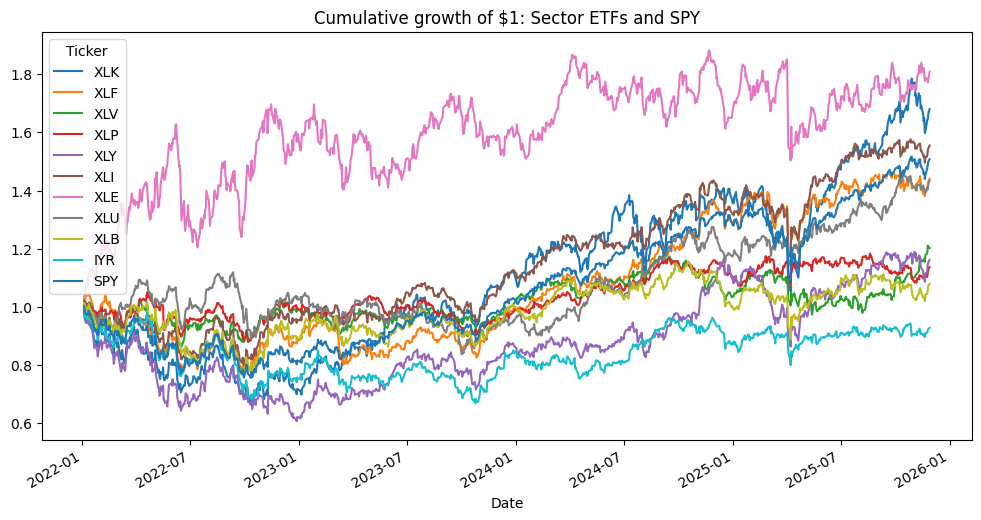

In [71]:
# Cumulative growth of $1 (simple returns)
(1 + rets[asset_cols + [bench_col]]).cumprod().plot(figsize=(12, 6))
plt.title("Cumulative growth of $1: Sector ETFs and SPY")
plt.show()

## 1.4 Factor Study vs Market (SPY) + rolling alpha/beta

### 1.4.1 Factor P&L returns *before* portfolio optimization

In [19]:
factors = ds["factors"].copy()

# Performance summary for factors (treating them as daily returns on $1 notional)

def perf_summary(r: pd.Series, rf: Optional[pd.Series] = None, trading_days: int = 252) -> pd.Series:
    r = r.dropna()
    if rf is not None:
        r = (r - rf.reindex(r.index)).dropna()

    wealth = (1 + r).cumprod()
    n = len(r)
    cagr = wealth.iloc[-1] ** (trading_days / n) - 1
    ann_vol = r.std() * (trading_days ** 0.5)
    ann_mean = r.mean() * trading_days
    sharpe = ann_mean / ann_vol if ann_vol > 0 else np.nan
    dd = wealth / wealth.cummax() - 1
    max_dd = dd.min()

    return pd.Series({
        "ann_mean": ann_mean,
        "ann_vol": ann_vol,
        "sharpe": sharpe,
        "cagr": cagr,
        "max_drawdown": max_dd,
        "skew": r.skew(),
        "kurtosis": r.kurtosis(),
    })

factor_perf = pd.DataFrame({c: perf_summary(factors[c], trading_days=cfg.trading_days) for c in factors.columns}).T
factor_perf


,ann_mean,ann_vol,sharpe,cagr,max_drawdown,skew,kurtosis
Mkt-RF,0.079457,0.187105,0.424667,0.063945,-0.256509,0.181286,6.304190
SMB,-0.056777,0.111720,-0.508208,-0.061059,-0.279876,0.652589,2.124170
HML,0.031886,0.142277,0.224110,0.022006,-0.230308,-0.098927,1.753159
RMW,0.011854,0.101235,0.117097,0.006764,-0.157992,0.277388,2.264575
CMA,-0.012677,0.096540,-0.131315,-0.017187,-0.285406,-0.168439,0.983096
MOM,-0.011281,0.128501,-0.087792,-0.019353,-0.135068,-0.324639,1.365430


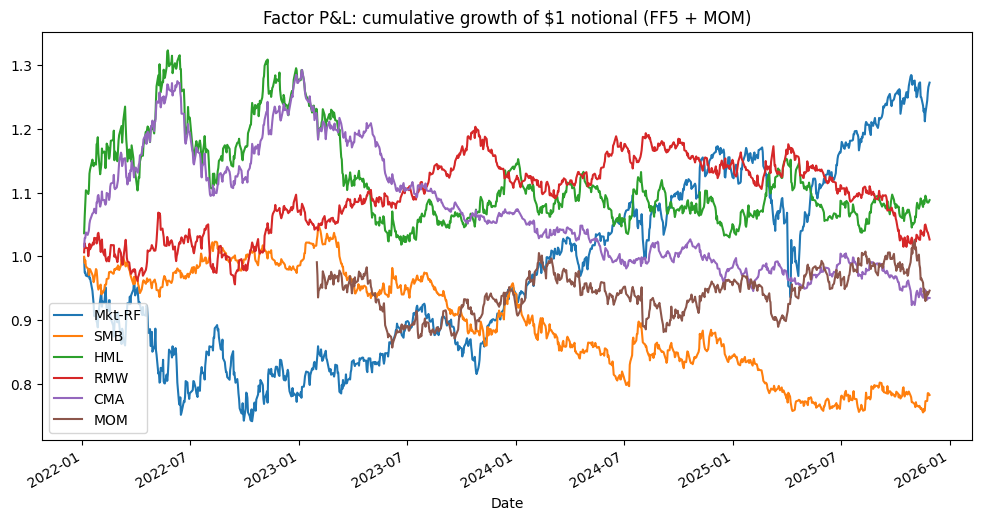

In [20]:
# Cumulative growth of $1 notional in each factor-mimicking return series
(1 + factors).cumprod().plot(figsize=(12, 6))
plt.title("Factor P&L: cumulative growth of $1 notional (FF5 + MOM)")
plt.show()


### 1.4.2 Systematic backtesting of factors vs the Market (SPY)

Study of the factors **with respect to market excess returns**.

We use SPY as the market proxy:

$$
\begin{align}
\text{MKT}_t \equiv R^{(e)}_{\text{SPY},t}
\end{align}
$$

For each factor \($F_t$\), run:

$$
\begin{align}
F_t = \alpha + \beta\,\text{MKT}_t + \varepsilon_t
\end{align}
$$

Then compute:

- \($\hat\beta$\): factor sensitivity to market
- \($\hat\alpha$\): market-neutral component
- Rolling \($\alpha,\beta$\) to see stability

In [21]:
def ols_alpha_beta(y: pd.Series, x: pd.Series, hac_lags: int = 5) -> pd.Series:
    """OLS regression y ~ 1 + x with HAC standard errors."""
    df = pd.concat([y, x], axis=1).dropna()
    yv = df.iloc[:, 0].values
    xv = sm.add_constant(df.iloc[:, 1].values)

    model = sm.OLS(yv, xv)
    res = model.fit(cov_type="HAC", cov_kwds={"maxlags": hac_lags})

    alpha, beta = res.params
    t_alpha, t_beta = res.tvalues

    return pd.Series({
        "alpha": alpha,
        "beta": beta,
        "t_alpha": t_alpha,
        "t_beta": t_beta,
        "n": int(res.nobs),
        "r2": float(res.rsquared),
    })

In [22]:
factors = ds["factors"].copy()

mkt = excess[bench_col].copy()

reg_rows = {}
for col in factors.columns:
    reg_rows[col] = ols_alpha_beta(factors[col], mkt)

factor_market_reg = pd.DataFrame(reg_rows).T
factor_market_reg

,alpha,beta,t_alpha,t_beta,n,r2
Mkt-RF,-0.000020,1.024911,-0.653307,81.303451,980.0,0.989984
SMB,-0.000255,0.090709,-1.187925,3.721179,980.0,0.021750
HML,0.000223,-0.294868,0.809206,-9.107180,980.0,0.141714
RMW,0.000107,-0.183001,0.586453,-8.021334,980.0,0.107813
CMA,0.000008,-0.177871,0.041925,-4.718490,980.0,0.112002
MOM,-0.000160,0.173522,-0.537502,2.460616,711.0,0.043705


### Plot: rolling beta of each factor vs SPY

A factor with near-zero rolling beta is relatively market-neutral.
A factor with time-varying beta indicates regime dependence.

In [23]:
def rolling_alpha_beta(y: pd.Series, x: pd.Series, window: int = 126) -> pd.DataFrame:
    """Fast rolling OLS for y ~ 1 + x (no HAC inside rolling; intended for visualization)."""
    df = pd.concat([y, x], axis=1).dropna()
    yv = df.iloc[:, 0].values
    xv = df.iloc[:, 1].values

    alphas = np.full(len(df), np.nan)
    betas = np.full(len(df), np.nan)

    for i in range(window - 1, len(df)):
        ys = yv[i - window + 1:i + 1]
        xs = xv[i - window + 1:i + 1]

        X = np.column_stack([np.ones(window), xs])
        # beta_hat = (X'X)^-1 X'y
        b = np.linalg.lstsq(X, ys, rcond=None)[0]
        alphas[i], betas[i] = b[0], b[1]

    out = pd.DataFrame({"alpha": alphas, "beta": betas}, index=df.index)
    return out

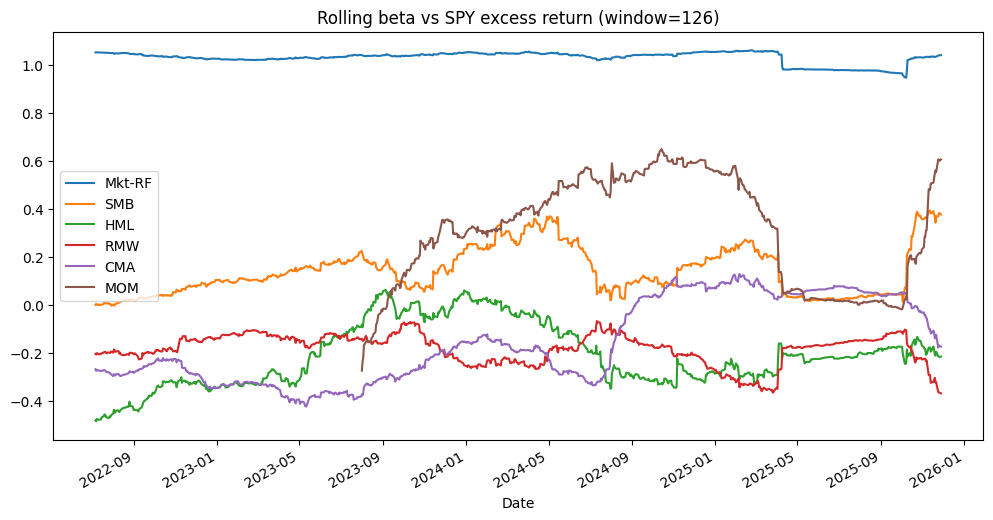

In [24]:
roll_window = 126  # about 6 months of trading days

plt.figure(figsize=(12, 6))
for col in factors.columns:
    rb = rolling_alpha_beta(factors[col], mkt, window=roll_window)["beta"]
    rb.plot(label=col)

plt.title(f"Rolling beta vs SPY excess return (window={roll_window})")
plt.legend()
plt.show()

### Plot: rolling alpha vs SPY (factors)

In the single-factor regression \(f_t = \\alpha + \\beta\,\\text{MKT}_t + \epsilon_t\), the intercept \(\\alpha\) measures the *average return of the factor not explained by the market*.

Below we plot a **rolling (annualized) alpha** estimate. A stable positive alpha over long windows is rare in small samples; expect noise.


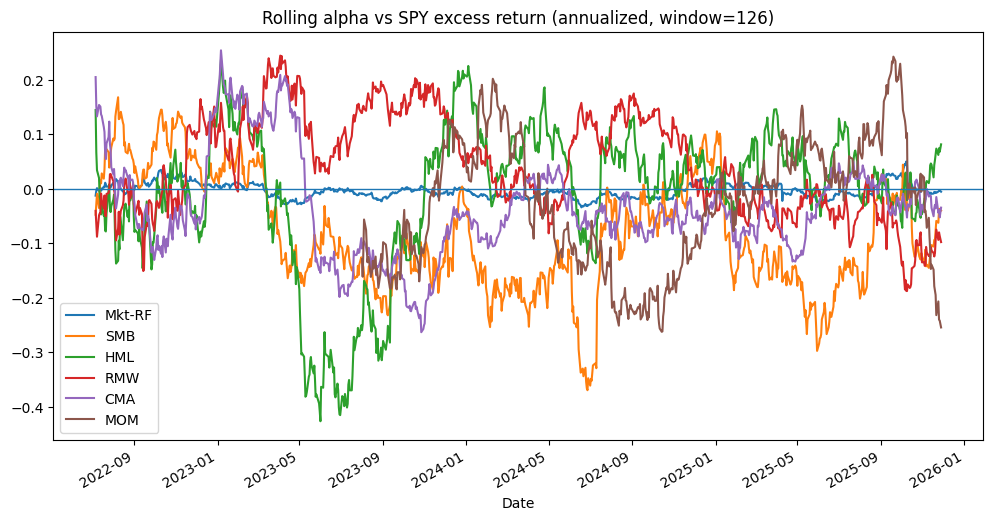

In [25]:
plt.figure(figsize=(12, 6))
for col in factors.columns:
    ra = rolling_alpha_beta(factors[col], mkt, window=roll_window)["alpha"] * cfg.trading_days
    ra.plot(label=col)

plt.title(f"Rolling alpha vs SPY excess return (annualized, window={roll_window})")
plt.axhline(0, linewidth=1)
plt.legend()
plt.show()


## 1.5 Baseline portfolio before Black-Litterman and Optimizations

Before doing any Black-Litterman or optimization, we create a simple baseline portfolio.

A natural baseline is **1/N** over the 10 sector ETFs.

This gives us something to compare against later.

In [26]:
w_equal = pd.Series(1.0 / len(asset_cols), index=asset_cols)

port_ret = rets[asset_cols].dot(w_equal)
port_excess = excess[asset_cols].dot(w_equal)

baseline_stats = pd.DataFrame({
    "EqualWeight": annualized_perf_stats(port_ret),
    "SPY": annualized_perf_stats(rets[bench_col])
}).T
baseline_stats

,ann_mean,ann_vol,sharpe
EqualWeight,0.091325,0.155905,0.585775
SPY,0.122082,0.181698,0.671894


### 1.5.1 Baseline Portfolio vs SPY

Interpretation checklist:

- Does the diversified sector basket reduce drawdowns?
- Does it materially lag SPY in strong bull regimes?
- Is tracking error acceptable for the narrative?

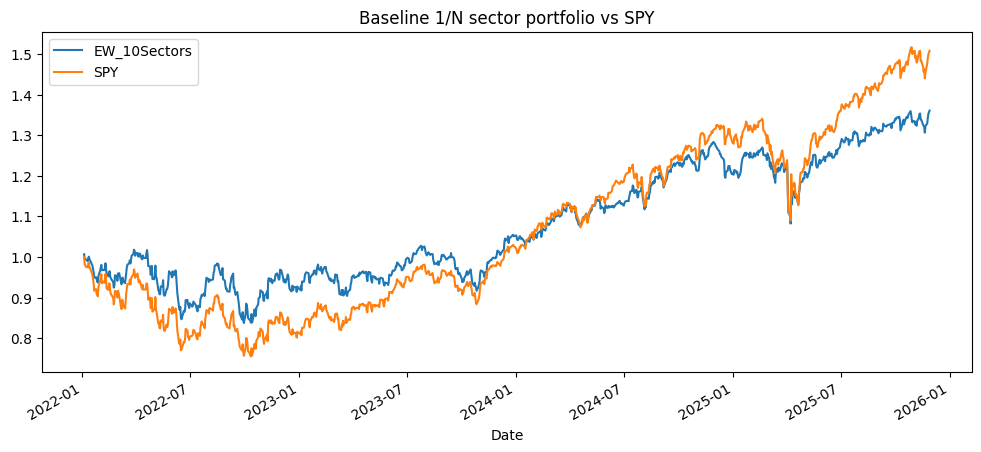

In [27]:
(1 + pd.DataFrame({
    "EW_10Sectors": port_ret,
    "SPY": rets[bench_col]
})).cumprod().plot(figsize=(12, 5))
plt.title("Baseline 1/N sector portfolio vs SPY")
plt.show()

### 1.5.2 Return's Factor Attribution Analysis (Ex-Post)

We perform a **Factor Attribution Analysis** to decompose the portfolio's realized returns into systematic risk exposures ("Beta") and idiosyncratic skill ("Alpha").

We regress the portfolio excess returns on the Fama-French 5-Factor model plus Momentum:

$$
\begin{align}
R^{(e)}_{p,t} = \alpha + \beta_{MKT}R_{MKT,t} + \beta_{SMB}R_{SMB,t} + \beta_{HML}R_{HML,t} + \beta_{RMW}R_{RMW,t} + \beta_{CMA}R_{CMA,t} + \beta_{MOM}R_{MOM,t} + \varepsilon_t
\end{align}
$$

#### Methodological Notes
1.  **HAC Standard Errors:** We use **Heteroskedasticity and Autocorrelation Consistent (Newey-West)** standard errors. Financial time series often exhibit volatility clustering; standard OLS assumptions would likely overestimate statistical significance (t-stats). HAC ensures our inference is robust.
2.  **Benchmark Adjustment:** We replace the academic Fama-French `Mkt-RF` factor with **SPY excess returns**. This measures our Market Beta ($\beta_{MKT}$) relative to the tradable S&P 500 index rather than the broad theoretical CRSP universe.
3.  **Alpha ($\alpha$):** The intercept represents the daily return *unexplained* by these factors. A positive, significant $\alpha$ indicates value added beyond static factor exposure.

In [28]:
def multi_factor_regression(y: pd.Series, X: pd.DataFrame, hac_lags: int = 5, ann_factor: int = 252) -> pd.Series:
    """Multi-factor regression y ~ 1 + X with HAC standard errors.

    Returns a *flat* Series that includes:
      - coefficients
      - t-stats (prefixed with t_)
      - R2 and n
      - annualized alpha (const*ann_factor) for convenience

    Notes
    -----
    * When y is a daily excess-return series, the intercept (const) is daily alpha.
      Annualized alpha is approx const * 252.
    """
    df = pd.concat([y, X], axis=1).dropna()
    yv = df.iloc[:, 0]
    Xv = sm.add_constant(df.iloc[:, 1:])

    res = sm.OLS(yv, Xv).fit(cov_type="HAC", cov_kwds={"maxlags": hac_lags})

    out = pd.Series(res.params)

    # t-statistics for quick inference
    for k, v in res.tvalues.items():
        out[f"t_{k}"] = v

    # Convenience: annualized alpha
    if "const" in res.params.index:
        out["alpha_ann"] = float(res.params["const"]) * ann_factor

    out["R2"] = float(res.rsquared)
    out["n"] = int(res.nobs)
    return out


In [29]:
X = factors.copy()
# Replace FF 'Mkt-RF' with SPY excess return to align with the benchmark definition
X = X.rename(columns={"Mkt-RF": "FF_MktRF"})
X["MKT_SPY"] = mkt

# Use SPY-based market factor + remaining FF factors + MOM
X_reg = X[["MKT_SPY", "SMB", "HML", "RMW", "CMA", "MOM"]]

reg_baseline = multi_factor_regression(port_excess, X_reg)
reg_baseline

const         -0.000113
MKT_SPY        0.825817
SMB            0.061946
HML            0.255329
RMW           -0.051602
CMA            0.105859
MOM           -0.130200
t_const       -1.357133
t_MKT_SPY     54.043917
t_SMB          3.110469
t_HML         10.610479
t_RMW         -2.078040
t_CMA          4.028353
t_MOM         -9.671472
alpha_ann     -0.028550
R2             0.916034
n            711.000000
dtype: float64

# Part 2 - Comparative Analysis of Black-Litterman (BL) outputs

## 2.1 Black-Litterman: priors, views, posteriors

### 1) Prior (equilibrium) expected returns

The core BL idea is to build a *prior* expected return vector \(\Pi\) implied by a benchmark portfolio \(w_{mkt}\):

\[
\Pi = \delta\,\Sigma\,w_{mkt}
\]

- \(\Sigma\): covariance matrix of **excess returns**
- \(\delta\): risk aversion (often calibrated from the benchmark)

### 2) Views (absolute and relative)

Views are linear constraints on expected returns:

\[
P\,\mu = Q
\]

- \(P\) is a **pick matrix** selecting assets and forming spreads
- \(Q\) is a vector of view returns

### 3) Posterior (BL) expected returns

A common BL posterior mean formula is:

\[
\mu_{BL} = \Pi + \tau\Sigma P^T\,(P\tau\Sigma P^T + \Omega)^{-1}(Q - P\Pi)
\]

We implement this directly.

### 4) How do we choose \(\tau\) and \(\Omega\)?

- \(\tau\) controls how uncertain we are about the prior.
- \(\Omega\) controls uncertainty in the views.

We implement two approaches:

1. **He-Litterman:** \(\Omega = \mathrm{diag}(P\tau\Sigma P^T)\)
2. **Idzorek-style confidence calibration:** solve for each \(\omega_k\) (diagonal of \(\Omega\)) to match a user confidence level.

## 2.1.1 Construct a benchmark weight vector over the 10 ETFs

BL needs a benchmark weight vector \(w_{mkt}\) **defined on the same assets** we optimize.

Since our benchmark is SPY, we estimate sector weights by a constrained replication:

\[
\min_{w} \; \mathrm{Var}(R_{SPY} - R_{sectors} w)
\quad\text{s.t.}\quad \sum_i w_i = 1,\; w_i \ge 0
\]

This gives a data-driven approximation to SPY's sector composition.

In [30]:
from scipy.optimize import minimize

In [31]:
def estimate_tracking_weights(returns_assets: pd.DataFrame, returns_benchmark: pd.Series) -> pd.Series:
    """Estimate benchmark-replicating weights by minimizing tracking error variance.

    Constraints: sum(w)=1, w>=0.
    """
    R = returns_assets.values
    b = returns_benchmark.values
    n = R.shape[1]

    def obj(w):
        diff = b - R @ w
        return float(np.var(diff, ddof=1))

    cons = ({"type": "eq", "fun": lambda w: np.sum(w) - 1.0},)
    bounds = [(0.0, 1.0) for _ in range(n)]
    w0 = np.ones(n) / n

    res = minimize(obj, w0, method="SLSQP", bounds=bounds, constraints=cons)
    if not res.success:
        raise RuntimeError(f"Tracking-weight optimization failed: {res.message}")

    w = pd.Series(res.x, index=returns_assets.columns)
    return w

In [32]:
# Use excess returns for the replication (benchmark = SPY excess)
w_mkt = estimate_tracking_weights(excess[asset_cols], excess[bench_col])
w_mkt

Ticker
XLK    0.1
XLF    0.1
XLV    0.1
XLP    0.1
XLY    0.1
XLI    0.1
XLE    0.1
XLU    0.1
XLB    0.1
IYR    0.1
dtype: float64

### 2.1.1.1 Benchmark replication diagnostics

We estimated \(w_{mkt}\) by minimizing tracking error to SPY using our 10 sector ETFs.

Good sanity checks:
- **Tracking error volatility** (annualized)
- **Correlation / R²** to SPY excess returns
- A bar chart of the inferred sector weights

If tracking error is large, treat \(\Pi\) and any BL results as **conditional on a coarse prior**.


In [33]:
# Replication diagnostics
rep = excess[asset_cols].dot(w_mkt)
te = excess[bench_col] - rep

# R^2 of regression benchmark ~ 1 + rep
import statsmodels.api as sm
res_rep = sm.OLS(excess[bench_col].loc[rep.index], sm.add_constant(rep)).fit()

diag = pd.Series({
    "sum_weights": float(w_mkt.sum()),
    "min_weight": float(w_mkt.min()),
    "max_weight": float(w_mkt.max()),
    "corr(rep, SPY_excess)": float(rep.corr(excess[bench_col].loc[rep.index])),
    "R2": float(res_rep.rsquared),
    "TE_vol_ann": float(te.std() * np.sqrt(cfg.trading_days)),
    "TE_mean_ann": float(te.mean() * cfg.trading_days),
})

diag


sum_weights              1.000000
min_weight               0.100000
max_weight               0.100000
corr(rep, SPY_excess)    0.936497
R2                       0.877027
TE_vol_ann               0.065268
TE_mean_ann              0.030757
dtype: float64

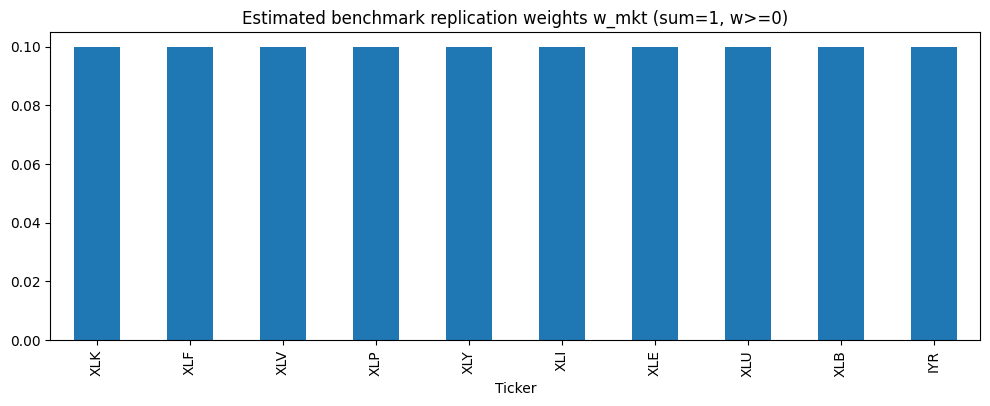

In [34]:
w_mkt.sort_values(ascending=False).plot(kind="bar", figsize=(12, 4))
plt.title("Estimated benchmark replication weights w_mkt (sum=1, w>=0)")
plt.show()


## 2.1.2 Risk aversion calibration (Market / Trustee / Kelly)

We use three standard levels:

- **Market**: calibrate from SPY (data-driven)
- **Trustee**: more risk-averse (typical number ~6)
- **Kelly**: more aggressive (typical number ~1)

A common market calibration uses:

\[
\delta_{mkt} = \frac{\mathbb{E}[R^{(e)}_{mkt}]}{\mathrm{Var}(R^{(e)}_{mkt})}
\]

Equivalently, \(\delta = \text{Sharpe} / \sigma\).

> In the course notes, an illustrative example uses Sharpe \(\approx 0.5\) and annual volatility \(\approx 22.35\%\), giving \(\delta \approx 2.24\).

We compute \(\delta_{mkt}\) from SPY excess returns in our sample.

In [35]:
def calibrate_market_risk_aversion(mkt_excess: pd.Series, trading_days: int = 252) -> float:
    mu = mkt_excess.mean() * trading_days
    var = mkt_excess.var(ddof=1) * trading_days
    if var <= 0:
        raise ValueError("Market variance is non-positive")
    return float(mu / var)


delta_mkt = calibrate_market_risk_aversion(excess[bench_col])

risk_aversion = {
    "Trustee": 6.0,
    "Market": float(delta_mkt),
    "Kelly": 1.0,
}

risk_aversion

{'Trustee': 6.0, 'Market': 2.50010505757124, 'Kelly': 1.0}

## 2.1.3 Implement Black-Litterman posterior

We implement:

- implied equilibrium returns \(\Pi\)
- BL posterior mean \(\mu_{BL}\)

We also compute an optional posterior covariance estimate used by some practitioners:

\[
\Sigma_{BL} = \Sigma + \Big((\tau\Sigma)^{-1} + P^T\Omega^{-1}P\Big)^{-1}
\]

(You can choose whether to optimize with \(\Sigma\) or \(\Sigma_{BL}\).)

In [36]:
def implied_equilibrium_returns(Sigma: pd.DataFrame, w_mkt: pd.Series, delta: float) -> pd.Series:
    """Pi = delta * Sigma * w_mkt (all in annualized units)."""
    # Ensure alignment
    w = w_mkt.reindex(Sigma.columns)
    pi = delta * Sigma.dot(w)
    pi.name = "Pi"
    return pi

In [37]:
def bl_posterior(
    Pi: pd.Series,
    Sigma: pd.DataFrame,
    P: np.ndarray,
    Q: np.ndarray,
    tau: float,
    Omega: np.ndarray,
) -> Tuple[pd.Series, pd.DataFrame]:
    """Compute BL posterior mean and an optional BL covariance.

    Parameters
    ----------
    Pi : pd.Series (N,)
        Prior expected excess returns.
    Sigma : pd.DataFrame (N,N)
        Covariance of excess returns.
    P : np.ndarray (K,N)
    Q : np.ndarray (K,)
    tau : float
    Omega : np.ndarray (K,K)

    Returns
    -------
    mu_bl : pd.Series (N,)
    Sigma_bl : pd.DataFrame (N,N)
    """
    Sigma_np = Sigma.values
    Pi_np = Pi.values.reshape(-1, 1)

    P = np.asarray(P, dtype=float)
    Q = np.asarray(Q, dtype=float).reshape(-1, 1)
    Omega = np.asarray(Omega, dtype=float)

    middle = np.linalg.inv(P @ (tau * Sigma_np) @ P.T + Omega)
    adj = (tau * Sigma_np) @ P.T @ middle @ (Q - P @ Pi_np)

    mu = Pi_np + adj
    mu = pd.Series(mu.flatten(), index=Sigma.index, name="mu_bl")

    # Posterior covariance of returns used in some BL implementations
    post_mean_uncert = np.linalg.inv(np.linalg.inv(tau * Sigma_np) + P.T @ np.linalg.inv(Omega) @ P)
    Sigma_bl = Sigma_np + post_mean_uncert
    Sigma_bl = pd.DataFrame(Sigma_bl, index=Sigma.index, columns=Sigma.columns)

    return mu, Sigma_bl

## 2.1.4 Specify a small set of views (absolute + relative)

We keep views **few** so the impact is interpretable.

Views (annualized excess returns):

1. **Relative (defensive vs tech):** (XLP + XLV)/2 - XLK = +2%
2. **Relative (financials vs discretionary):** XLF - XLY = +1%
3. **Absolute:** XLE = +5%

You can change magnitudes and confidence later.

In [38]:
assets = asset_cols
N = len(assets)

asset_to_idx = {a:i for i,a in enumerate(assets)}

def p_row(weights: Dict[str, float]) -> np.ndarray:
    row = np.zeros(N)
    for k, v in weights.items():
        row[asset_to_idx[k]] = v
    return row

P = np.vstack([
    p_row({"XLP": 0.5, "XLV": 0.5, "XLK": -1.0}),
    p_row({"XLF": 1.0, "XLY": -1.0}),
    p_row({"XLE": 1.0}),
])

Q = np.array([
    0.02,  # 2% annual outperformance of defensive basket vs tech
    0.01,  # 1% annual outperformance of financials vs discretionary
    0.05,  # 5% annual expected excess return for energy
])

view_names = [
    "(XLP+XLV)/2 - XLK = +2%",
    "XLF - XLY = +1%",
    "XLE = +5%",
]

pd.DataFrame(P, index=view_names, columns=assets)

,XLK,XLF,XLV,XLP,XLY,XLI,XLE,XLU,XLB,IYR
(XLP+XLV)/2 - XLK = +2%,-1.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0
XLF - XLY = +1%,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
XLE = +5%,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## 2.1.5 View uncertainty Omega

### (A) He-Litterman default

\[
\Omega = \mathrm{diag}(P\,\tau\Sigma\,P^T)
\]

### (B) Idzorek-style confidence calibration (implemented)

Idzorek proposes mapping intuitive confidence levels (0-100%) into \(\omega_k\) values.

We implement the practical version described in the guide:

- compute the 100%-confidence weights implied by each view alone,
- scale the tilt by confidence,
- choose \(\omega_k\) so the BL portfolio weights match the target.

This is a **1D numerical problem per view** and is a meaningful place to show quant judgment.

In [39]:
def omega_he_litterman(P: np.ndarray, Sigma: pd.DataFrame, tau: float) -> np.ndarray:
    Sigma_np = Sigma.values
    mat = P @ (tau * Sigma_np) @ P.T
    return np.diag(np.diag(mat))

In [40]:
def bl_mean_single_view(
    Pi: pd.Series,
    Sigma: pd.DataFrame,
    p: np.ndarray,
    q: float,
    tau: float,
    omega: float,
) -> pd.Series:
    """BL posterior mean for a single view (p, q, omega).

    Notes
    -----
    For a single view, the key scalar quantity is:

        denom = p (tau * Sigma) p' + omega

    When `p` is treated as a 2D row vector (shape (1, N)), NumPy returns a 1x1 array.
    Converting that to a Python float requires extracting the scalar via `.item()`.
    """

    N = Sigma.shape[0]
    p = np.asarray(p, dtype=float).reshape(1, N)

    Sigma_np = Sigma.to_numpy(dtype=float)
    Pi_np = Pi.to_numpy(dtype=float).reshape(-1, 1)

    # Scalar denominator and scalar view mispricing
    denom = (p @ (tau * Sigma_np) @ p.T).item() + float(omega)
    if denom <= 0:
        raise ValueError("Non-positive single-view denominator; check Sigma, tau, omega, p")

    delta = float(q) - (p @ Pi_np).item()

    # N x 1 adjustment
    middle = 1.0 / denom
    adj = (tau * Sigma_np) @ p.T * middle * delta

    mu = Pi_np + adj
    return pd.Series(mu.flatten(), index=Sigma.index)


In [41]:
def idzorek_omega_from_confidence(
    Pi: pd.Series,
    Sigma: pd.DataFrame,
    w_mkt: pd.Series,
    P: np.ndarray,
    Q: np.ndarray,
    conf: np.ndarray,
    tau: float,
    lam: float,
) -> np.ndarray:
    """Compute diagonal Omega via Idzorek-style confidence calibration.

    This routine calibrates each view's scalar uncertainty \Omega_{kk} so that the
    *implied* unconstrained mean-variance weights reproduce an intuitive tilt that
    is proportional to the user's confidence level.

    Implementation details
    ----------------------
    - For each view k, compute the *100% confidence* (omega = 0) posterior mean.
    - Map posterior means to unconstrained MV weights via w = (1/lam) Sigma^{-1} mu.
    - Define a target weight vector by applying a confidence-scaled version of the
      100% tilt *only* to assets involved in the view.
    - Find omega_k (via 1D bounded search on log-omega) such that the resulting MV
      weights match the target on the view assets.

    Parameters
    ----------
    conf : np.ndarray (K,)
        Confidence levels in [0,1].
    lam : float
        Risk aversion used in the unconstrained mean-variance mapping w = (1/lam) Sigma^{-1} mu.

    Returns
    -------
    Omega : np.ndarray (K,K)
        Diagonal covariance of view errors.
    """

    from scipy.optimize import minimize_scalar

    K, N = P.shape
    Sigma_np = Sigma.to_numpy(dtype=float)
    Sigma_inv = np.linalg.inv(Sigma_np)

    omega_diag = np.zeros(K)

    for k in range(K):
        pk = np.asarray(P[k], dtype=float).reshape(1, N)
        qk = float(Q[k])
        ck = float(conf[k])

        # Sanity: view variance should be positive
        var_view = (pk @ (tau * Sigma_np) @ pk.T).item()
        if var_view <= 0:
            raise ValueError("Non-positive view variance")

        # 100% confidence posterior mean for view k alone
        mu_100 = bl_mean_single_view(Pi, Sigma, P[k], qk, tau=tau, omega=0.0)

        # Unconstrained weights implied by mu_100
        w_100 = (1.0 / lam) * (Sigma_inv @ mu_100.to_numpy(dtype=float))
        w_100 = pd.Series(w_100, index=Sigma.index)

        D_100 = w_100 - w_mkt.reindex(Sigma.index)

        # Apply confidence tilt only to assets in the view
        mask = (np.abs(P[k]) > 1e-12)
        tilt = pd.Series(0.0, index=Sigma.index)
        tilt.iloc[mask] = D_100.iloc[mask] * ck

        w_target = w_mkt.reindex(Sigma.index) + tilt

        # Objective: pick omega so that the implied MV weights match w_target on the view assets
        def obj(log_omega):
            omega = float(np.exp(log_omega))
            mu = bl_mean_single_view(Pi, Sigma, P[k], qk, tau=tau, omega=omega)
            w = (1.0 / lam) * (Sigma_inv @ mu.to_numpy(dtype=float))
            w = pd.Series(w, index=Sigma.index)
            diff = (w.iloc[mask] - w_target.iloc[mask]).to_numpy(dtype=float)
            return float(np.sum(diff ** 2))

        # Search omega on log-scale for numerical stability
        res = minimize_scalar(obj, bounds=(-20, 20), method='bounded')
        omega_diag[k] = float(np.exp(res.x))

    return np.diag(omega_diag)


In [42]:
# Annualize covariance (excess returns)
Sigma_ann = excess[asset_cols].cov() * cfg.trading_days

# Prior
tau = 0.05
Pi = implied_equilibrium_returns(Sigma_ann, w_mkt, delta=risk_aversion["Market"])

# Omega approaches
Omega_HL = omega_he_litterman(P, Sigma_ann, tau=tau)

conf = np.array([0.60, 0.50, 0.40])  # user confidence per view in [0,1]
Omega_Idz = idzorek_omega_from_confidence(
    Pi=Pi,
    Sigma=Sigma_ann,
    w_mkt=w_mkt,
    P=P,
    Q=Q,
    conf=conf,
    tau=tau,
    lam=risk_aversion["Market"],
)

Omega_HL, Omega_Idz

(array([[0.002614  , 0.        , 0.        ],
        [0.        , 0.00153811, 0.        ],
        [0.        , 0.        , 0.00339299]]),
 array([[0.00174266, 0.        , 0.        ],
        [0.        , 0.00153811, 0.        ],
        [0.        , 0.        , 0.00508949]]))

In [43]:
# Compute posteriors (choose Omega_Idz by default)
mu_bl, Sigma_bl = bl_posterior(Pi, Sigma_ann, P, Q, tau=tau, Omega=Omega_Idz)

pd.DataFrame({
    "ImpliedEq(Pi)": Pi,
    "BL_posterior": mu_bl,
}).sort_values("BL_posterior", ascending=False)

,ImpliedEq(Pi),BL_posterior
Ticker,,
XLB,0.068235,0.055956
IYR,0.063400,0.055618
XLF,0.065020,0.054729
XLE,0.060314,0.052344
XLY,0.081556,0.051800
XLI,0.063399,0.049327
XLU,0.045402,0.044602
XLV,0.044292,0.042437
XLK,0.079882,0.041946


### 2.1.3 Visual check: implied vs posterior expected returns

A fast way to see the *effect of views* is to compare \(\Pi\) (implied equilibrium returns) to \(\mu_{BL}\) (posterior).

Below:
- a bar chart (sorted by posterior)
- a scatter plot vs the 45° line

Large deviations typically correspond to strong views (large \(|Q|\)) and/or high confidence (small \(\Omega\)).


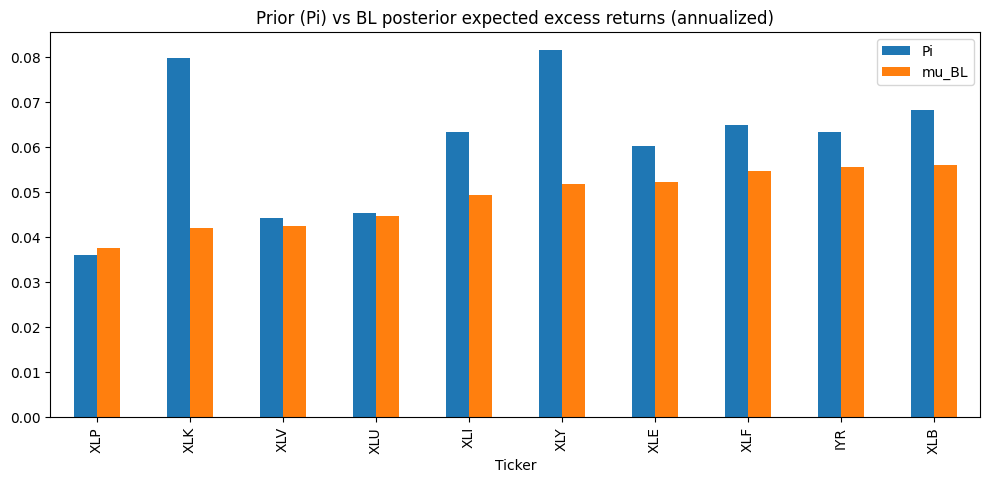

In [44]:
mu_comp = pd.DataFrame({"Pi": Pi, "mu_BL": mu_bl})
mu_comp.sort_values("mu_BL")[["Pi", "mu_BL"]].plot(kind="bar", figsize=(12, 5))
plt.title("Prior (Pi) vs BL posterior expected excess returns (annualized)")
plt.show()


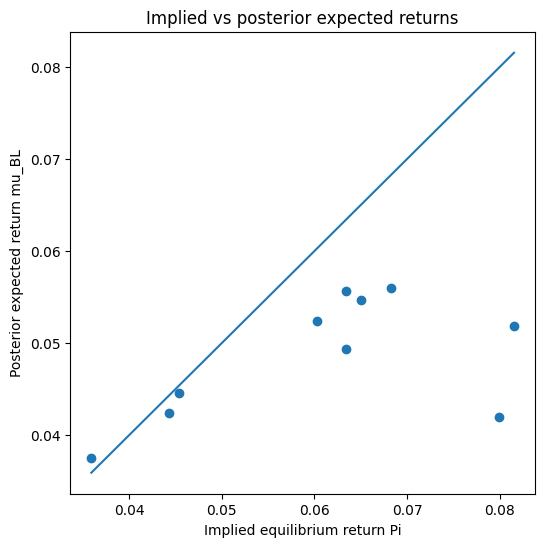

In [45]:
plt.figure(figsize=(6, 6))
plt.scatter(Pi, mu_bl)

mn = float(min(Pi.min(), mu_bl.min()))
mx = float(max(Pi.max(), mu_bl.max()))
plt.plot([mn, mx], [mn, mx])

plt.xlabel("Implied equilibrium return Pi")
plt.ylabel("Posterior expected return mu_BL")
plt.title("Implied vs posterior expected returns")
plt.show()


## 2.2 Optimization 1: Mean-Variance (Markowitz)

We solve the constrained mean-variance problem:

\[
\max_w\; \mu^T w - \frac{\lambda}{2} w^T \Sigma w
\quad\text{s.t.}\quad \sum_i w_i = 1,\; \ell_i \le w_i \le u_i
\]

- We use **excess returns** for \(\mu\).
- We solve using **SLSQP**.

We compute optimal allocations for three risk aversions:

- Trustee: \(\lambda=6\)
- Market: \(\lambda=\delta_{mkt}\) (calibrated)
- Kelly: \(\lambda=1\)

And we compare:

- using prior returns \(\Pi\)
- using posterior returns \(\mu_{BL}\)

In [46]:
def mean_variance_opt(
    mu: pd.Series,
    Sigma: pd.DataFrame,
    lam: float,
    bounds: Tuple[float, float] = (-0.30, 0.30),
) -> pd.Series:
    """Constrained mean-variance optimization with sum(w)=1 and box constraints."""

    mu = mu.reindex(Sigma.index)
    Sigma_np = Sigma.values
    mu_np = mu.values

    n = len(mu)

    def obj(w):
        # minimize: (lam/2) w'Σw - μ'w
        return float(0.5 * lam * (w @ Sigma_np @ w) - (mu_np @ w))

    cons = ({"type": "eq", "fun": lambda w: np.sum(w) - 1.0},)
    bnds = [bounds for _ in range(n)]
    w0 = np.ones(n) / n

    res = minimize(obj, w0, method="SLSQP", bounds=bnds, constraints=cons)
    if not res.success:
        raise RuntimeError(f"Mean-variance optimization failed: {res.message}")

    w = pd.Series(res.x, index=mu.index)
    return w

In [47]:
# Choose which covariance to use in optimization:
# - Sigma_ann: historical covariance
# - Sigma_bl: BL-adjusted covariance
Sigma_for_opt = Sigma_ann

bounds = (-0.35, 0.35)

mv_results = []
for name, lam in risk_aversion.items():
    w_pi = mean_variance_opt(Pi, Sigma_for_opt, lam=lam, bounds=bounds)
    w_bl = mean_variance_opt(mu_bl, Sigma_for_opt, lam=lam, bounds=bounds)

    mv_results.append(pd.DataFrame({
        "w_prior(Pi)": w_pi,
        "w_posterior(BL)": w_bl,
        "benchmark_w_mkt": w_mkt,
    }).rename_axis("asset").assign(risk_aversion=name))

mv_table = pd.concat(mv_results).reset_index()
mv_table.head()

,asset,w_prior(Pi),w_posterior(BL),benchmark_w_mkt,risk_aversion
0,XLK,0.061672,-0.052692,0.1,Trustee
1,XLF,0.018819,0.062738,0.1,Trustee
2,XLV,0.231285,0.312000,0.1,Trustee
3,XLP,0.350000,0.350000,0.1,Trustee
4,XLY,0.010823,-0.018408,0.1,Trustee


In [48]:
# Show allocations for each risk aversion level
for ra in risk_aversion.keys():
    display(
        mv_table[mv_table["risk_aversion"] == ra]
        .set_index("asset")
        .drop(columns=["risk_aversion"])
        .sort_values("w_posterior(BL)", ascending=False)
    )

,w_prior(Pi),w_posterior(BL),benchmark_w_mkt
asset,,,
XLP,0.350000,0.350000,0.1
XLV,0.231285,0.312000,0.1
XLI,0.185066,0.184866,0.1
XLU,0.120464,0.138426,0.1
XLE,0.098297,0.095626,0.1
XLF,0.018819,0.062738,0.1
XLY,0.010823,-0.018408,0.1
IYR,-0.025439,-0.023851,0.1
XLB,-0.050987,-0.048705,0.1


,w_prior(Pi),w_posterior(BL),benchmark_w_mkt
asset,,,
XLP,0.1,0.235507,0.1
XLV,0.1,0.226030,0.1
XLF,0.1,0.185517,0.1
XLB,0.1,0.111367,0.1
XLI,0.1,0.101954,0.1
IYR,0.1,0.098515,0.1
XLU,0.1,0.096747,0.1
XLE,0.1,0.089417,0.1
XLY,0.1,0.004834,0.1


,w_prior(Pi),w_posterior(BL),benchmark_w_mkt
asset,,,
XLF,0.274179,0.350000,0.1
XLB,0.350000,0.350000,0.1
IYR,0.350000,0.350000,0.1
XLV,-0.327566,0.160086,0.1
XLU,0.021791,0.122935,0.1
XLE,0.108067,0.106421,0.1
XLY,0.350000,0.099640,0.1
XLI,0.030063,0.070106,0.1
XLP,-0.350000,-0.259188,0.1


### Plot: MV allocations (posterior) across risk aversion

Interpretation checklist:

- As \(\lambda\) increases (more risk-averse), weights should generally move toward the benchmark and/or lower-risk exposures.
- Views should create intuitive tilts relative to the benchmark weights.

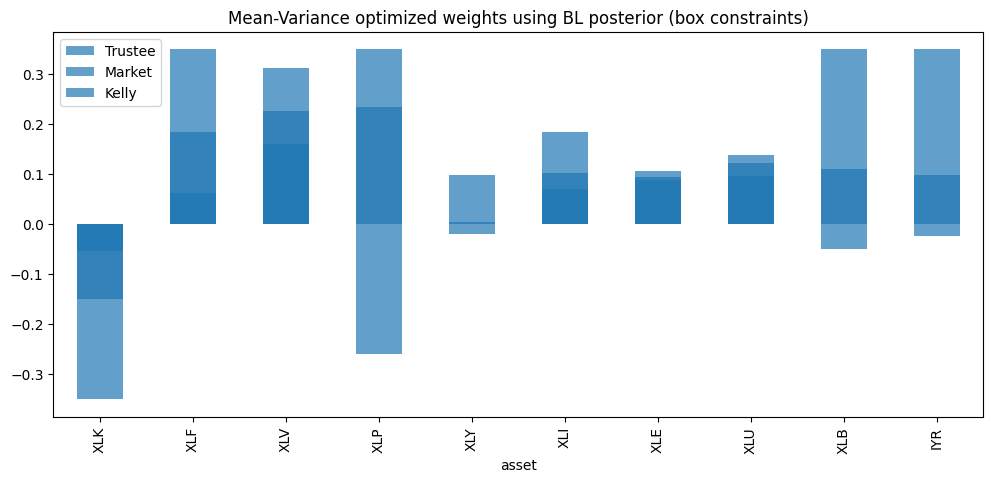

In [49]:
fig, ax = plt.subplots(figsize=(12, 5))

for ra in risk_aversion.keys():
    w = mv_table[mv_table["risk_aversion"] == ra].set_index("asset")["w_posterior(BL)"]
    w.plot(kind="bar", alpha=0.7, label=ra)

plt.title("Mean-Variance optimized weights using BL posterior (box constraints)")
plt.legend()
plt.show()

## 2.2.1 BL output visualisations: allocations along the efficient frontier (Meucci-style)

The workshop slides include a very useful diagnostic plot: **portfolio composition as we move along the efficient frontier** (volatility on the x-axis, weights on the y-axis) for:

- the **reference model** (prior returns \(\Pi\))
- the **posterior model** (BL-updated returns \(\mu_{BL}\))

This makes it easy to see whether a model produces **corner solutions** and how BL views change allocations **across risk levels**, not only at one chosen risk-aversion setting.

Because our project portfolio is **long/short**, we show two versions:

1. **Long-only frontier** (closest in spirit to the classic Meucci/Idzorek visuals).
2. **Long/short frontier**, stacking long exposure above 0 and short exposure below 0 (interpretable as *net exposure* and *gross leverage*).


**Reference (from the workshop deck):** the following figure illustrates the *composition vs volatility* diagnostic for a reference vs posterior BL model.

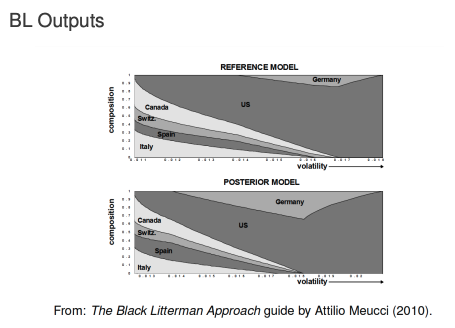

We recreate this diagnostic below for our own 10-ETF universe.


In [50]:
def portfolio_stats(mu: pd.Series, Sigma: pd.DataFrame, w: pd.Series) -> Tuple[float, float, float]:
    """Return/volatility/Sharpe for annualized excess-return inputs.

    Parameters
    ----------
    mu : expected excess returns (annualized)
    Sigma : covariance of excess returns (annualized)
    w : portfolio weights

    Returns
    -------
    (ret, vol, sharpe) all annualized (Sharpe uses rf=0 since inputs are excess).
    """
    mu = mu.reindex(Sigma.index)
    w = w.reindex(Sigma.index)
    ret = float(mu @ w)
    var = float(w.values @ Sigma.values @ w.values)
    vol = float(np.sqrt(max(var, 1e-16)))
    sharpe = float(ret / vol) if vol > 0 else np.nan
    return ret, vol, sharpe


def mean_variance_opt_frontier(
    mu: pd.Series,
    Sigma: pd.DataFrame,
    lam: float,
    bounds: Tuple[float, float],
    w0: Optional[np.ndarray] = None,
) -> Tuple[pd.Series, bool]:
    """MV optimiser used for efficient-frontier scanning (warm-start capable).

    Objective (minimisation form):
        0.5 * lam * w' Sigma w  -  mu' w

    Constraints:
        sum(w) = 1
        bounds[0] <= w_i <= bounds[1]
    """
    mu = mu.reindex(Sigma.index)
    Sigma_np = Sigma.values
    mu_np = mu.values
    n = len(mu)

    if w0 is None:
        w0 = np.ones(n) / n
    else:
        w0 = np.asarray(w0, dtype=float)
        if w0.shape != (n,):
            raise ValueError('w0 has wrong shape')

    def obj(w):
        return float(0.5 * lam * (w @ Sigma_np @ w) - (mu_np @ w))

    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0},)
    bnds = [bounds for _ in range(n)]

    res = minimize(
        obj,
        w0,
        method='SLSQP',
        bounds=bnds,
        constraints=cons,
        options={'maxiter': 500},
    )

    w = pd.Series(res.x, index=mu.index, name=f'w_lam_{lam:g}')
    return w, bool(res.success)


def compute_mv_frontier(
    mu: pd.Series,
    Sigma: pd.DataFrame,
    lam_grid: np.ndarray,
    bounds: Tuple[float, float],
) -> pd.DataFrame:
    """Compute an MV efficient frontier by sweeping risk aversion values.

    Returns a DataFrame with columns: lambda, ret, vol, sharpe, and one column per asset weight.
    """
    rows = []
    w0 = None

    for lam in lam_grid:
        w, ok = mean_variance_opt_frontier(mu, Sigma, lam=float(lam), bounds=bounds, w0=w0)
        if not ok:
            # fallback: restart from equal weights once
            w, ok2 = mean_variance_opt_frontier(mu, Sigma, lam=float(lam), bounds=bounds, w0=None)
            ok = ok2
        w0 = w.values.copy()

        ret, vol, sharpe = portfolio_stats(mu, Sigma, w)
        row = {'lambda': float(lam), 'ret': ret, 'vol': vol, 'sharpe': sharpe, 'success': ok}
        row.update(w.to_dict())
        rows.append(row)

    df = pd.DataFrame(rows)
    # Sort by realised volatility so x-axis is monotone (like in Meucci-style plots)
    df = df.sort_values('vol').reset_index(drop=True)
    return df


def plot_composition_long_only(frontier: pd.DataFrame, assets: list, title: str) -> None:
    x = frontier['vol'].values
    W = frontier[assets].T.values

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.stackplot(x, W, labels=assets)
    ax.set_title(title)
    ax.set_xlabel('Volatility (annualized)')
    ax.set_ylabel('Portfolio weight')
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()


def plot_composition_long_short(frontier: pd.DataFrame, assets: list, title: str) -> None:
    """Stack long weights above 0 and short weights below 0.

    Notes
    -----
    With long/short constraints and sum(w)=1, the long stack can exceed 1.0
    (gross leverage), while the short stack is negative.
    """
    x = frontier['vol'].values
    W = frontier[assets].values

    # Use matplotlib default color cycle for consistent asset colours
    cycle = plt.rcParams['axes.prop_cycle'].by_key().get('color', [])
    color_map = {a: cycle[i % len(cycle)] for i, a in enumerate(assets)} if cycle else {}

    fig, ax = plt.subplots(figsize=(12, 5))

    # Long stack
    base = np.zeros_like(x, dtype=float)
    for j, a in enumerate(assets):
        y = np.clip(W[:, j], 0.0, None)
        if np.allclose(y, 0.0):
            continue
        ax.fill_between(x, base, base + y, label=a, color=color_map.get(a, None), alpha=0.9)
        base = base + y

    # Short stack
    base = np.zeros_like(x, dtype=float)
    for j, a in enumerate(assets):
        y = -np.clip(W[:, j], None, 0.0)  # positive magnitude
        if np.allclose(y, 0.0):
            continue
        ax.fill_between(x, base, base - y, color=color_map.get(a, None), alpha=0.9)
        base = base - y

    ax.axhline(0.0, linewidth=1.0)
    ax.set_title(title)
    ax.set_xlabel('Volatility (annualized)')
    ax.set_ylabel('Weight (long above 0 / short below 0)')
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()


In [51]:
# Sweep a wide range of risk-aversion values (log grid)
lam_grid = np.logspace(-2, 2, 60)  # 0.01 .. 100

# Constraint sets
bounds_long_only = (0.0, 0.35)
bounds_long_short = (-0.35, 0.35)

front_lo_prior = compute_mv_frontier(Pi, Sigma_for_opt, lam_grid=lam_grid, bounds=bounds_long_only)
front_lo_post  = compute_mv_frontier(mu_bl, Sigma_for_opt, lam_grid=lam_grid, bounds=bounds_long_only)

front_ls_prior = compute_mv_frontier(Pi, Sigma_for_opt, lam_grid=lam_grid, bounds=bounds_long_short)
front_ls_post  = compute_mv_frontier(mu_bl, Sigma_for_opt, lam_grid=lam_grid, bounds=bounds_long_short)

front_lo_prior[['vol','ret','sharpe']].head()


,vol,ret,sharpe
0,0.127855,0.044236,0.345989
1,0.127857,0.044260,0.346167
2,0.127860,0.044292,0.346409
3,0.127867,0.044350,0.346845
4,0.127873,0.044397,0.347197


### Long-only composition plots (closest to the slide-style visual)

These plots replicate the *shape* of the "composition vs volatility" diagnostic from the workshop deck, but using our 10-ETF universe.


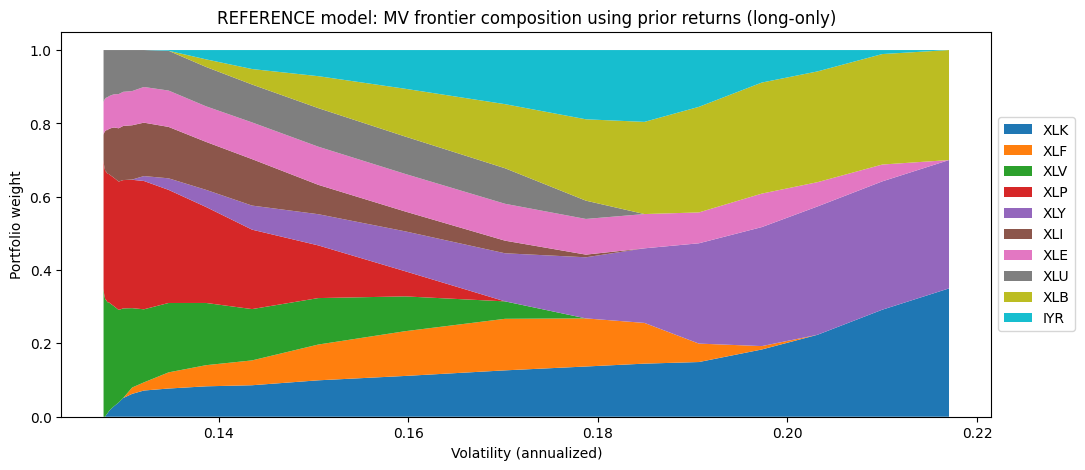

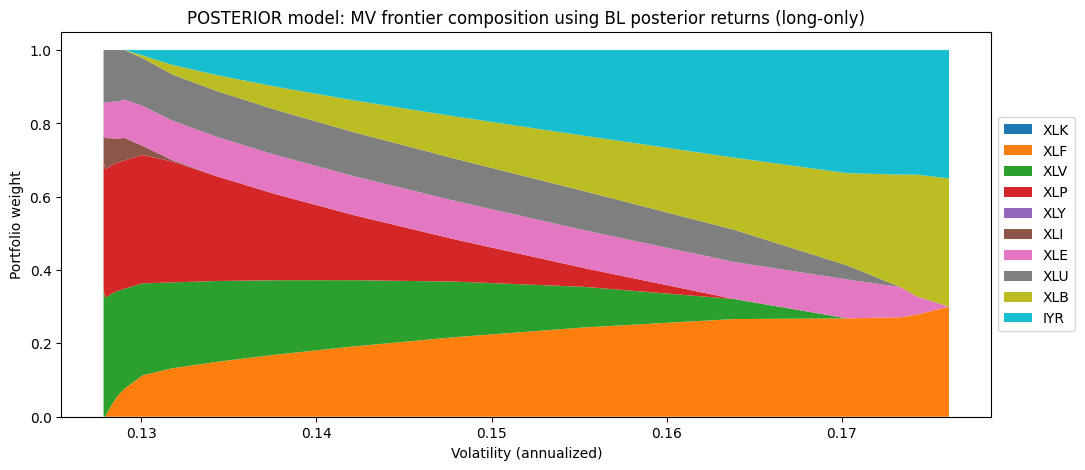

In [52]:
plot_composition_long_only(front_lo_prior, asset_cols, title='REFERENCE model: MV frontier composition using prior returns (long-only)')
plot_composition_long_only(front_lo_post,  asset_cols, title='POSTERIOR model: MV frontier composition using BL posterior returns (long-only)')


### Long/short composition plots (net weights + gross leverage)

Because we allow shorting (box constraints), the long stack can exceed 100% (gross leverage > 1)
and the short stack appears below 0.


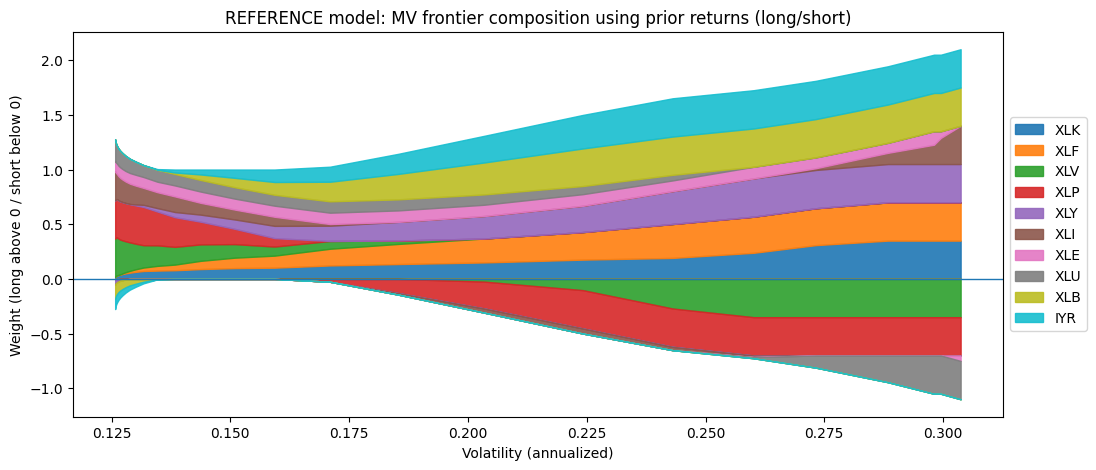

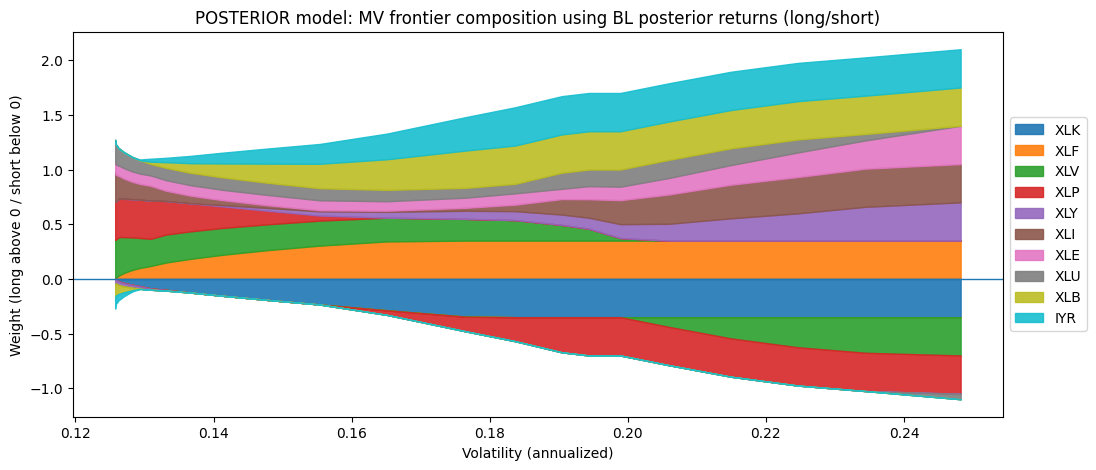

In [53]:
plot_composition_long_short(front_ls_prior, asset_cols, title='REFERENCE model: MV frontier composition using prior returns (long/short)')
plot_composition_long_short(front_ls_post,  asset_cols, title='POSTERIOR model: MV frontier composition using BL posterior returns (long/short)')


### Efficient frontier curves (return vs volatility)

We also plot the efficient frontiers implied by the prior vs the BL posterior.
The three labelled points correspond to the Trustee / Market / Kelly risk-aversion levels (under the same long/short constraints).


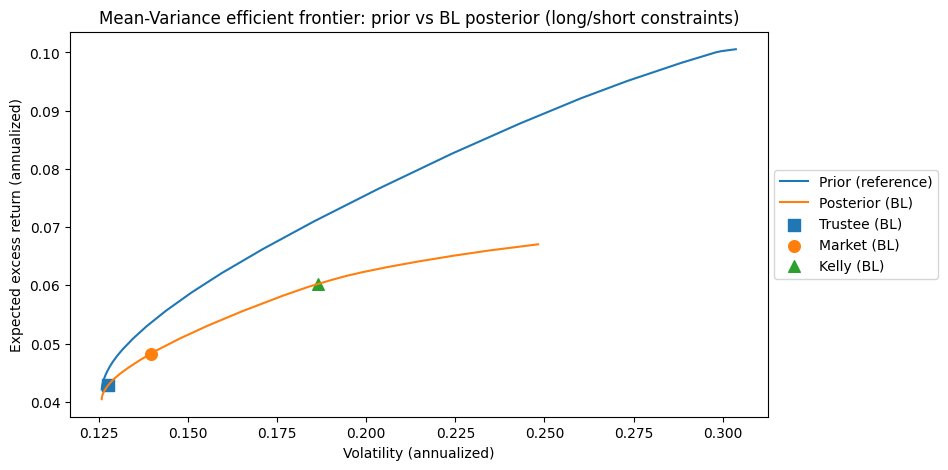

In [54]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(front_ls_prior['vol'], front_ls_prior['ret'], label='Prior (reference)')
ax.plot(front_ls_post['vol'],  front_ls_post['ret'],  label='Posterior (BL)')

# Mark the three risk-aversion points on the BL frontier
markers = {'Trustee': 's', 'Market': 'o', 'Kelly': '^'}
for name, lam in risk_aversion.items():
    w_pt, ok = mean_variance_opt_frontier(mu_bl, Sigma_for_opt, lam=float(lam), bounds=bounds_long_short, w0=None)
    r_pt, v_pt, _ = portfolio_stats(mu_bl, Sigma_for_opt, w_pt)
    ax.scatter([v_pt], [r_pt], marker=markers.get(name, 'o'), s=70, label=f'{name} (BL)')

ax.set_title('Mean-Variance efficient frontier: prior vs BL posterior (long/short constraints)')
ax.set_xlabel('Volatility (annualized)')
ax.set_ylabel('Expected excess return (annualized)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()


## 2.3 Optimization 2: Maximum Sharpe Ratio

We compute the maximum Sharpe portfolio over risky assets:

\[
\max_w \frac{\mu^T w}{\sqrt{w^T \Sigma w}}
\quad\text{s.t.}\quad \sum_i w_i = 1,\; \ell_i \le w_i \le u_i
\]

This produces the **tangency** portfolio (under constraints).

Then, to incorporate "risk aversion" we can scale the tangency portfolio by allocating to cash:

\[
\text{allocation to tangency} \; y = \frac{\mu_T}{\lambda\,\sigma_T^2}
\]

(This step is optional but gives a clean Trustee/Market/Kelly comparison.)

In [55]:
def max_sharpe_opt(
    mu: pd.Series,
    Sigma: pd.DataFrame,
    bounds: Tuple[float, float] = (-0.30, 0.30),
) -> pd.Series:
    """Constrained max Sharpe (tangency) portfolio with sum(w)=1."""

    mu = mu.reindex(Sigma.index)
    Sigma_np = Sigma.values
    mu_np = mu.values

    n = len(mu)

    def neg_sharpe(w):
        ret = mu_np @ w
        vol2 = w @ Sigma_np @ w
        vol = np.sqrt(max(vol2, 1e-12))
        return float(-ret / vol)

    cons = ({"type": "eq", "fun": lambda w: np.sum(w) - 1.0},)
    bnds = [bounds for _ in range(n)]
    w0 = np.ones(n) / n

    res = minimize(neg_sharpe, w0, method="SLSQP", bounds=bnds, constraints=cons)
    if not res.success:
        raise RuntimeError(f"Max-Sharpe optimization failed: {res.message}")

    return pd.Series(res.x, index=mu.index)

In [56]:
w_tan_prior = max_sharpe_opt(Pi, Sigma_for_opt, bounds=bounds)
w_tan_bl = max_sharpe_opt(mu_bl, Sigma_for_opt, bounds=bounds)

pd.DataFrame({
    "Tangency_prior": w_tan_prior,
    "Tangency_BL": w_tan_bl,
    "benchmark_w_mkt": w_mkt,
}).sort_values("Tangency_BL", ascending=False)

,Tangency_prior,Tangency_BL,benchmark_w_mkt
Ticker,,,
XLP,0.1,0.229115,0.1
XLV,0.1,0.228742,0.1
XLF,0.1,0.193503,0.1
XLB,0.1,0.102908,0.1
XLU,0.1,0.101247,0.1
IYR,0.1,0.099862,0.1
XLI,0.1,0.098485,0.1
XLE,0.1,0.091977,0.1
XLY,0.1,0.008145,0.1


In [57]:
def portfolio_mean_var(mu: pd.Series, Sigma: pd.DataFrame, w: pd.Series) -> Tuple[float, float]:
    mu = mu.reindex(Sigma.index)
    w = w.reindex(Sigma.index)
    m = float(mu @ w)
    v = float(w @ Sigma.values @ w)
    return m, v

mu_T, var_T = portfolio_mean_var(mu_bl, Sigma_for_opt, w_tan_bl)

allocations = {}
for name, lam in risk_aversion.items():
    y = mu_T / (lam * var_T)
    allocations[name] = y

allocations

{'Trustee': 0.4129011828455463,
 'Market': 0.9909211973195988,
 'Kelly': 2.4774070970732778}

Interpretation:

- If \(y>1\), the investor would lever the tangency portfolio (borrow at rf).
- If \(y<1\), the investor holds some cash.

In practice, leverage/margin constraints would cap \(y\). This is exactly why constraints matter.

## 2.4 Systematic backtesting of BL portfolios

We perform a simple train/test split:

- use the first ~70% of data to estimate \(\Sigma\), \(\Pi\), BL posterior, and weights
- test performance on the remaining ~30% with **no rebalancing**

Then we:

- compare cumulative P&L vs SPY
- regress portfolio excess returns on factors (FF5 + MOM)
- inspect rolling betas

In [58]:
def train_test_split_index(idx: pd.DatetimeIndex, train_frac: float = 0.7) -> Tuple[pd.DatetimeIndex, pd.DatetimeIndex]:
    cut = int(len(idx) * train_frac)
    return idx[:cut], idx[cut:]

train_idx, test_idx = train_test_split_index(excess.index, train_frac=0.7)
train_idx[0], train_idx[-1], test_idx[0], test_idx[-1]

(Timestamp('2022-01-04 00:00:00'),
 Timestamp('2024-09-26 00:00:00'),
 Timestamp('2024-09-27 00:00:00'),
 Timestamp('2025-11-28 00:00:00'))

In [59]:
# Build train objects
ex_train = excess.loc[train_idx, asset_cols]
spy_train = excess.loc[train_idx, bench_col]

Sigma_train = ex_train.cov() * cfg.trading_days
w_mkt_train = estimate_tracking_weights(ex_train, spy_train)

# Calibrate delta on train
delta_train = calibrate_market_risk_aversion(spy_train)

Pi_train = implied_equilibrium_returns(Sigma_train, w_mkt_train, delta=delta_train)
Omega_train = omega_he_litterman(P, Sigma_train, tau=tau)

mu_bl_train, _ = bl_posterior(Pi_train, Sigma_train, P, Q, tau=tau, Omega=Omega_train)

# Choose one risk aversion level for portfolio comparison (e.g., Market)
lam = delta_train

w_mv_train = mean_variance_opt(mu_bl_train, Sigma_train, lam=lam, bounds=bounds)
w_tan_train = max_sharpe_opt(mu_bl_train, Sigma_train, bounds=bounds)

w_mv_train, w_tan_train

(Ticker
 XLK   -0.164888
 XLF    0.208383
 XLV    0.211791
 XLP    0.215440
 XLY   -0.016194
 XLI    0.109067
 XLE    0.129189
 XLU    0.099910
 XLB    0.113218
 IYR    0.094084
 dtype: float64,
 Ticker
 XLK   -0.161859
 XLF    0.202132
 XLV    0.225312
 XLP    0.225533
 XLY   -0.009147
 XLI    0.097361
 XLE    0.132713
 XLU    0.096993
 XLB    0.095703
 IYR    0.095258
 dtype: float64)

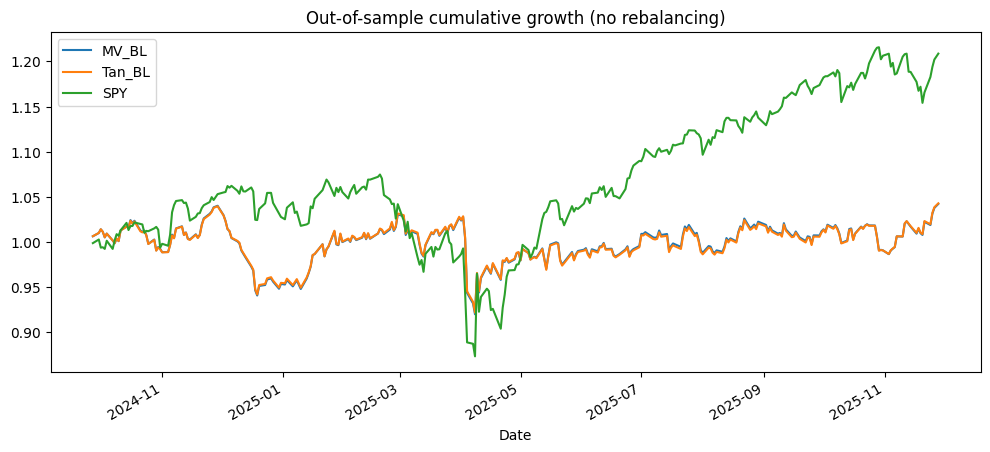

In [60]:
# Apply weights on test (no rebalancing)
ret_test = rets.loc[test_idx, asset_cols]
ex_test = excess.loc[test_idx, asset_cols]
spy_test = rets.loc[test_idx, bench_col]

p_mv = ret_test.dot(w_mv_train)
p_tan = ret_test.dot(w_tan_train)

perf = pd.DataFrame({
    "MV_BL": p_mv,
    "Tan_BL": p_tan,
    "SPY": spy_test,
})

(1 + perf).cumprod().plot(figsize=(12, 5))
plt.title("Out-of-sample cumulative growth (no rebalancing)")
plt.show()

### 2.4.1 Out-of-sample performance table and drawdowns

To make the backtest easier to interpret, we summarize:
- CAGR (geometric)
- annualized volatility
- Sharpe ratio (using the daily risk-free series)
- max drawdown

Then we plot drawdowns for MV_BL, Tan_BL, and SPY.


In [61]:
rf_test = rf_daily.loc[test_idx].reindex(perf.index).dropna()

perf_stats = pd.DataFrame({
    name: perf_summary(perf[name].loc[rf_test.index], rf=rf_test, trading_days=cfg.trading_days)
    for name in perf.columns
}).T
perf_stats


,ann_mean,ann_vol,sharpe,cagr,max_drawdown,skew,kurtosis
MV_BL,0.004072,0.139280,0.029233,-0.005621,-0.128204,-0.666625,9.755484
Tan_BL,0.004500,0.138476,0.032496,-0.005084,-0.126057,-0.675758,9.633402
SPY,0.138903,0.187478,0.740905,0.129224,-0.192076,1.391891,23.553111


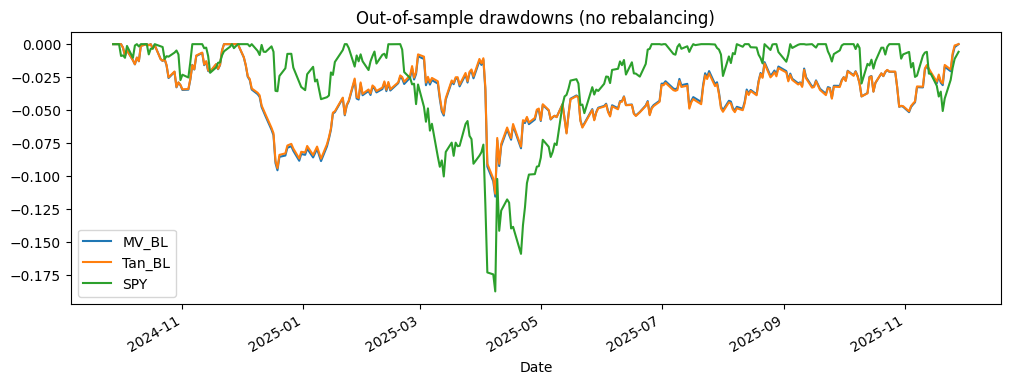

In [62]:
wealth = (1 + perf.loc[rf_test.index]).cumprod()
dd = wealth / wealth.cummax() - 1

dd.plot(figsize=(12, 4))
plt.title("Out-of-sample drawdowns (no rebalancing)")
plt.show()


### 2.4.2 Rolling market beta of BL portfolios (out-of-sample)

We now compute rolling \(\\alpha\) and \(\\beta\) of portfolio **excess returns** against SPY **excess returns**:

\[
(r^{p}_t - r^f_t) = \\alpha + \\beta\,(r^{SPY}_t - r^f_t) + \epsilon_t
\]

This matches the brief's request to compare performance vs the market using rolling beta/alpha.


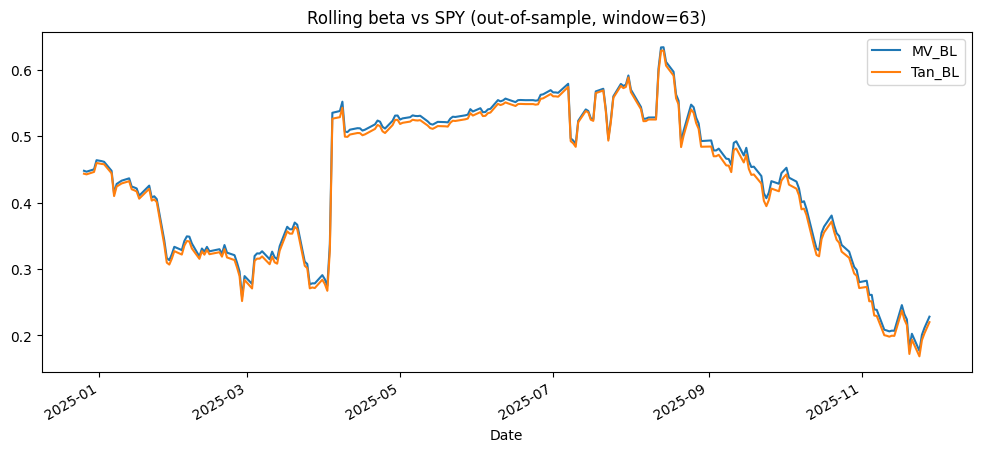

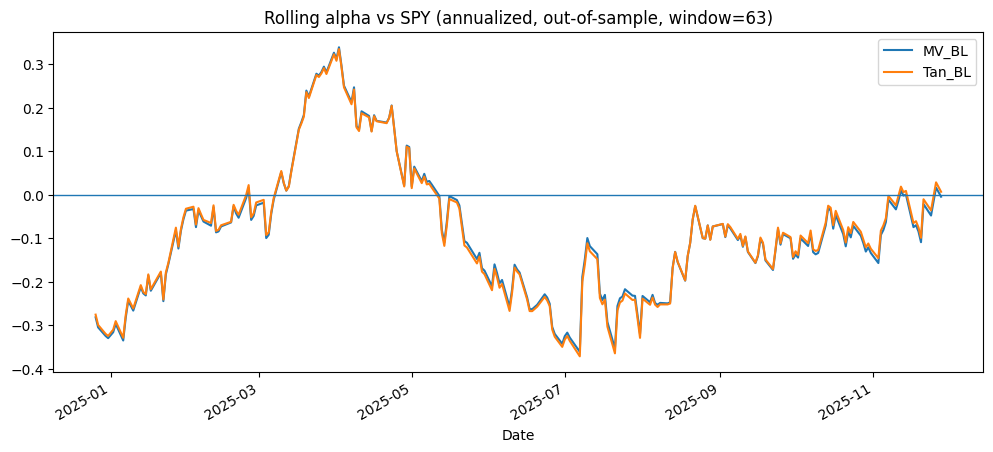

In [63]:
mkt_ex_test = (perf["SPY"].loc[rf_test.index] - rf_test)

port_excess = pd.DataFrame({
    "MV_BL": perf["MV_BL"].loc[rf_test.index] - rf_test,
    "Tan_BL": perf["Tan_BL"].loc[rf_test.index] - rf_test,
})

w = 63  # ~1 quarter
plt.figure(figsize=(12, 5))
for col in port_excess.columns:
    rb = rolling_alpha_beta(port_excess[col], mkt_ex_test, window=w)["beta"]
    rb.plot(label=col)

plt.title(f"Rolling beta vs SPY (out-of-sample, window={w})")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
for col in port_excess.columns:
    ra = rolling_alpha_beta(port_excess[col], mkt_ex_test, window=w)["alpha"] * cfg.trading_days
    ra.plot(label=col)

plt.title(f"Rolling alpha vs SPY (annualized, out-of-sample, window={w})")
plt.axhline(0, linewidth=1)
plt.legend()
plt.show()


### Factor regression (out-of-sample)

We regress **portfolio excess returns** on factors.

In [64]:
factors_test = factors.loc[test_idx].copy()

# Market factor defined as SPY excess return
mkt_test = excess.loc[test_idx, bench_col]

X_test = factors_test.rename(columns={"Mkt-RF": "FF_MktRF"})
X_test["MKT_SPY"] = mkt_test
X_reg_test = X_test[["MKT_SPY", "SMB", "HML", "RMW", "CMA", "MOM"]]

mv_excess_test = ex_test.dot(w_mv_train)
tan_excess_test = ex_test.dot(w_tan_train)

reg_mv_test = multi_factor_regression(mv_excess_test, X_reg_test)
reg_tan_test = multi_factor_regression(tan_excess_test, X_reg_test)

pd.DataFrame({
    "MV_BL": reg_mv_test,
    "Tan_BL": reg_tan_test,
})

,MV_BL,Tan_BL
const,-0.000353,-0.000349
MKT_SPY,0.611917,0.605689
SMB,0.016443,0.010984
HML,0.567176,0.560917
RMW,-0.072669,-0.072898
CMA,0.046548,0.044020
MOM,-0.291811,-0.298070
t_const,-1.387821,-1.376581
t_MKT_SPY,16.320569,16.354937
t_SMB,0.208470,0.139477


## 2.5 Optional: ex-ante risk contributions

For a weight vector \(w\) and covariance \(\Sigma\):

- portfolio volatility: \(\sigma_p = \sqrt{w^T\Sigma w}\)
- marginal contribution: \(\partial\sigma_p/\partial w = \Sigma w / \sigma_p\)
- component contribution: \(RC_i = w_i (\Sigma w)_i / \sigma_p\)

This is useful for diagnosing concentration.

In [65]:
def risk_contributions(w: pd.Series, Sigma: pd.DataFrame) -> pd.Series:
    w = w.reindex(Sigma.index)
    Sw = Sigma.values @ w.values
    vol = np.sqrt(max(float(w.values @ Sw), 1e-12))
    rc = w.values * Sw / vol
    return pd.Series(rc, index=w.index)

rc_mv = risk_contributions(w_mv_train, Sigma_train)
rc_tan = risk_contributions(w_tan_train, Sigma_train)

pd.DataFrame({
    "RC_MV": rc_mv,
    "RC_Tan": rc_tan,
}).sort_values("RC_MV", ascending=False)

,RC_MV,RC_Tan
Ticker,,
XLF,0.032994,0.031882
XLV,0.024227,0.026006
XLP,0.022755,0.024021
XLE,0.021859,0.022431
XLB,0.018517,0.015522
XLI,0.015604,0.013853
IYR,0.015274,0.015467
XLU,0.013575,0.013195
XLY,-0.002338,-0.001325


## 2.6 Optional extension: treat FF5 + MOM as investable long/short "assets"

The project brief encourages introducing factor time series and treating them as investable assets.

One clean way to demonstrate this is to **augment** the universe with factor-mimicking portfolios:

- FF5: **Mkt-RF, SMB, HML, RMW, CMA**
- plus our custom **MOM**

Important interpretation note:

- These are typically **self-financing long/short portfolios** (especially SMB/HML/RMW/CMA/MOM).
- Treating them as "assets with weights that sum to 1" is a **pedagogical simplification**. A more realistic implementation would interpret weights as notional exposures with margin constraints.

In this section we still run the same machinery to show how allocations change when factors are allowed directly in the allocation.

In [66]:
# Build an augmented return matrix: 10 ETF excess returns + FF5 factors + MOM
# (All are excess-return series in this implementation.)

factor_cols = ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "MOM"]

aug = pd.concat([
    excess[asset_cols],              # ETF excess returns
    factors[factor_cols],            # factor returns
], axis=1).dropna()

aug_mu = aug.mean() * cfg.trading_days
aug_Sigma = aug.cov() * cfg.trading_days

# Mean-variance on augmented universe (pick one lambda for illustration)
lam_demo = risk_aversion["Market"]

w_aug = mean_variance_opt(aug_mu, aug_Sigma, lam=lam_demo, bounds=(-0.25, 0.25))
w_aug.sort_values(ascending=False)

XLK       0.250000
XLF       0.250000
XLY       0.250000
XLV       0.250000
XLI       0.250000
RMW       0.250000
XLU       0.250000
Mkt-RF    0.250000
XLP       0.250000
HML      -0.048795
XLE      -0.068122
MOM      -0.133083
CMA      -0.250000
SMB      -0.250000
XLB      -0.250000
IYR      -0.250000
dtype: float64

## 2.7 Robustness and stress tests (statistics + numerics)

A quant-quality notebook should check **how fragile** the outputs are.

Below are lightweight tests that directly address bias/variance and numerical stability:

1. **Covariance estimation error:** sample covariance vs shrinkage.
2. **BL hyperparameter sensitivity:** how allocations move when \(\tau\) changes.
3. **Optimizer diagnostics:** whether SLSQP converged and whether weights hit constraints.

These checks are also useful as report material: they justify why constraints and BL are used.

In [67]:
from sklearn.covariance import LedoitWolf

# 1) Covariance shrinkage
#    Sample covariance can be noisy and ill-conditioned in small samples.
#    Ledoit-Wolf shrinkage reduces estimation variance (at the cost of some bias).

lw = LedoitWolf().fit(excess[asset_cols].values)
Sigma_lw = pd.DataFrame(lw.covariance_ * cfg.trading_days, index=asset_cols, columns=asset_cols)

# Condition numbers (higher -> more numerically fragile)
cond_sample = np.linalg.cond(Sigma_for_opt.values)
cond_lw = np.linalg.cond(Sigma_lw.values)

# Compare allocations under different covariances (keep the SAME expected returns)
w_mv_bl_sample = mean_variance_opt(mu_bl, Sigma_for_opt, lam=risk_aversion["Market"], bounds=bounds)
w_mv_bl_lw = mean_variance_opt(mu_bl, Sigma_lw, lam=risk_aversion["Market"], bounds=bounds)

comp = pd.DataFrame({
    "MV_BL_sampleCov": w_mv_bl_sample,
    "MV_BL_LedoitWolf": w_mv_bl_lw,
})
comp["abs_diff"] = (comp["MV_BL_sampleCov"] - comp["MV_BL_LedoitWolf"]).abs()

summary = pd.Series({
    "cond_sample": cond_sample,
    "cond_ledoitwolf": cond_lw,
    "L1_weight_distance": float(comp["abs_diff"].sum()),
    "max_abs_weight_diff": float(comp["abs_diff"].max()),
})

summary, comp.sort_values("abs_diff", ascending=False)

# 2) Sensitivity to tau (BL hyperparameter)
#    If allocations swing drastically when tau changes slightly, results are fragile.

tau_grid = [0.01, 0.05, 0.10]
rows = []
for tau_ in tau_grid:
    # Recompute BL posterior with fixed Omega_Idz (note: Omega is often scaled with tau; here we keep view uncertainty mechanism consistent)
    Omega_ = omega_he_litterman(P, Sigma_ann, tau=tau_)
    mu_bl_tau, _ = bl_posterior(Pi, Sigma_ann, P, Q, tau=tau_, Omega=Omega_)
    w_tau = mean_variance_opt(mu_bl_tau, Sigma_for_opt, lam=risk_aversion["Market"], bounds=bounds)
    rows.append(w_tau.rename(f"tau={tau_}"))

tau_weights = pd.concat(rows, axis=1)
tau_weights.loc[:, :]  # display

,tau=0.01,tau=0.05,tau=0.1
Ticker,,,
XLK,-0.107485,-0.107485,-0.107485
XLF,0.193580,0.193580,0.193580
XLV,0.208689,0.208689,0.208689
XLP,0.215478,0.215478,0.215478
XLY,-0.005790,-0.005790,-0.005790
XLI,0.106888,0.106888,0.106888
XLE,0.084244,0.084244,0.084244
XLU,0.098032,0.098032,0.098032
XLB,0.110872,0.110872,0.110872


In [68]:
# Re-run MV (posterior) with shrinkage covariance and compare to sample-cov weights

w_mv_bl_sample = mean_variance_opt(mu_bl, Sigma_for_opt, lam=risk_aversion["Market"], bounds=bounds)
w_mv_bl_lw = mean_variance_opt(mu_bl, Sigma_lw, lam=risk_aversion["Market"], bounds=bounds)

compare = pd.DataFrame({
    "MV_BL_sample": w_mv_bl_sample,
    "MV_BL_LedoitWolf": w_mv_bl_lw,
    "diff": (w_mv_bl_lw - w_mv_bl_sample),
})
compare.loc[asset_cols].sort_values("diff", ascending=False)

,MV_BL_sample,MV_BL_LedoitWolf,diff
IYR,0.098515,0.103186,0.004671
XLU,0.096747,0.099432,0.002685
XLB,0.111367,0.113778,0.002412
XLK,-0.149889,-0.147721,0.002168
XLE,0.089417,0.090586,0.001168
XLY,0.004834,0.005580,0.000746
XLI,0.101954,0.101128,-0.000827
XLF,0.185517,0.184395,-0.001122
XLV,0.226030,0.221095,-0.004935
XLP,0.235507,0.228540,-0.006967


In [69]:
# 2) tau sensitivity: recompute BL posterior means for a few tau values

tau_grid = [0.01, 0.05, 0.10]

weights_by_tau = {}
for tau_test in tau_grid:
    mu_tau, _ = bl_posterior(Pi, Sigma_ann, P, Q, tau=tau_test, Omega=Omega_Idz)
    w_tau = mean_variance_opt(mu_tau, Sigma_for_opt, lam=risk_aversion["Market"], bounds=bounds)
    weights_by_tau[tau_test] = w_tau

w_tau_df = pd.DataFrame(weights_by_tau)
w_tau_df.loc[asset_cols]

,0.01,0.05,0.10
Ticker,,,
XLK,-0.001071,-0.149889,-0.210167
XLF,0.141595,0.185517,0.193010
XLV,0.151928,0.226030,0.254361
XLP,0.155282,0.235507,0.266795
XLY,0.053152,0.004834,-0.001929
XLI,0.102351,0.101954,0.099443
XLE,0.094275,0.089417,0.090316
XLU,0.098871,0.096747,0.095122
XLB,0.105126,0.111367,0.113229


### Interpreting robustness outputs

- If weights swing wildly across \(\tau\) or across covariance estimators, your solution is **estimation-error dominated**.
- If many weights sit exactly at their bounds, your **constraints are binding** and you should interpret results as a constrained solution rather than a pure signal.
- If the condition number of \(\Sigma\) is extremely large, consider:
  - shrinkage covariance,
  - reducing the universe,
  - or using factor models for \(\Sigma\).

# Wrap-up and next steps

At this stage you have:

- A clean **Phase 0 dataset builder** (prices, rf, excess returns, FF5, custom MOM)
- Systematic factor study vs SPY (alphas/betas + rolling beta)
- Baseline portfolio and factor regression
- Black-Litterman prior/posterior implementation
- Two optimizations (Mean-Variance + Max Sharpe)
- Out-of-sample backtesting (no rebalancing)
- Optional risk contribution diagnostics

From here, the report write-up can reuse the outputs:

- tables of implied vs posterior returns (Idzorek-style)
- allocation comparisons vs benchmark weights
- rolling alpha/beta plots
- regression tables and interpretation

You can now refine:

- the view magnitudes \(Q\)
- confidence levels
- constraints (e.g., leverage, sector max/min)
- covariance estimator (sample vs shrinkage)